# Sistema di Face Detection per una fotocamera digitale

## Contesto del Progetto
La ProCam S.p.A. è pronta a lanciare una nuova fotocamera digitale compatta, accessibile e pensata per i giovani appassionati di fotografia. L'obiettivo principale del prodotto è facilitare l'esperienza di scatto, in particolare per i selfie con una o più persone.

## Sfida
Sei stato assunto come Data Scientist per sviluppare un sistema di rilevamento volti nelle immagini, che aiuterà i tecnici a ottimizzare automaticamente le impostazioni della fotocamera durante i selfie. Il tuo compito è realizzare una pipeline che identifichi i volti presenti nelle immagini e restituisca le coordinate dei bounding box dove i volti sono individuati. Se non ci sono volti, la pipeline restituirà una lista vuota.

Si tratta di un problema di Computer Vision, più precisamente di Face Detection.

## Requisiti del Progetto
Obiettivo: Costruire un sistema di rilevamento dei volti utilizzando Scikit-learn. La pipeline deve essere in grado di:

Prendere un’immagine in ingresso.
Restituire una lista di coordinate dei bounding box dove sono presenti volti.
Restituire una lista vuota se nell’immagine non ci sono volti.

## Limitazioni:

#### Dataset:
Non ti viene fornito un dataset. Devi cercare un dataset adatto in rete o, in mancanza di alternative, costruirlo tu stesso.
Modelli pre-addestrati: Non è consentito utilizzare modelli pre-addestrati. Il modello di Face Detection dovrà essere addestrato da zero con Scikit-learn.

#### Risorse di calcolo:
Lavorerai su un sistema con capacità di calcolo limitate. Il modello dovrà essere ottimizzato per utilizzare poche risorse.

#### Documentazione:
La soluzione deve essere ben documentata. Ogni decisione adottata (scelta degli algoritmi, preprocessamento, tecniche di ottimizzazione) dovrà essere spiegata. Inoltre, ogni risorsa esterna utilizzata (paper accademici, articoli di blog, codice GitHub) dovrà essere citata.

####  Ricerca bibliografica:
Poiché non ti vengono fornite indicazioni dettagliate sull'implementazione, è essenziale condurre un'approfondita ricerca bibliografica per identificare le soluzioni migliori. Dovrai analizzare approcci già esistenti e adattarli alle limitazioni del progetto.


## Conclusione
La realizzazione di un sistema di rilevamento volti con risorse limitate e senza dataset preconfezionato è una sfida che richiede una forte capacità di problem-solving e adattamento. Una pipeline ben ottimizzata e documentata non solo contribuirà al successo del lancio del prodotto ProCam, ma rappresenterà anche un passo significativo nella tua crescita professionale come Data Scientist.



In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC


from skimage.feature import hog

import os
from PIL import Image
import cv2

from sklearn.datasets import fetch_olivetti_faces

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Definizione di funzioni utili


In [ ]:
# funzione per caricamento immagine sottoforma di array a partire da un determinato path

def load_imgs_as_array(path):
  image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
  images = []
  for image_file in image_files:
      image_path = os.path.join(path, image_file)
      img = cv2.imread(image_path)
      gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      images.append(gray_img)
  return images

# funzione per il calcolo delle metriche utili alla valutazione delle performance del modello

def compute_indices(y_true, y_predicted, show_definitions = True, print_values = True):
    accuracy = round(accuracy_score(y_true, y_predicted), 3)
    precision = round(precision_score(y_true, y_predicted),3)
    f1 = round(f1_score(y_true, y_predicted),3)
    recall = round(recall_score(y_true, y_predicted),3)

    indices = [accuracy, precision, f1, recall]

    if show_definitions:
        print("\n\n\nAccuracy tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.\n\nPrecision measures the proportion of positively predicted labels that are actually correct.\n\nRecall represents the model’s ability to correctly predict the positives out of actual positives.\n\nF1 score is harmonic mean of precision and recall score. It gives equal weight to both the Precision and Recall for measuring its performance in terms of accuracy thereby making it an alternative to Accuracy metrics (it doesn’t require us to know the total number of observations).")
    if print_values:
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")
    return indices;




## Dataset per la classe positiva
Il dataset che rappresenterà la classe positiva con cui addestrare il modello di face detection è il noto dataset "olivetti faces" di sci-kit learn, contenente 10 immagini di volti appartenenti a 40 differenti soggetti, quindi un totale di 400 campioni, in bianco e nero e di risoluzione 64x64.

Di seguito il riferimento: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

In [ ]:
# dataset per la classe positiva

faces = fetch_olivetti_faces()
#print(faces.DESCR)

positive_cl = faces.images*255

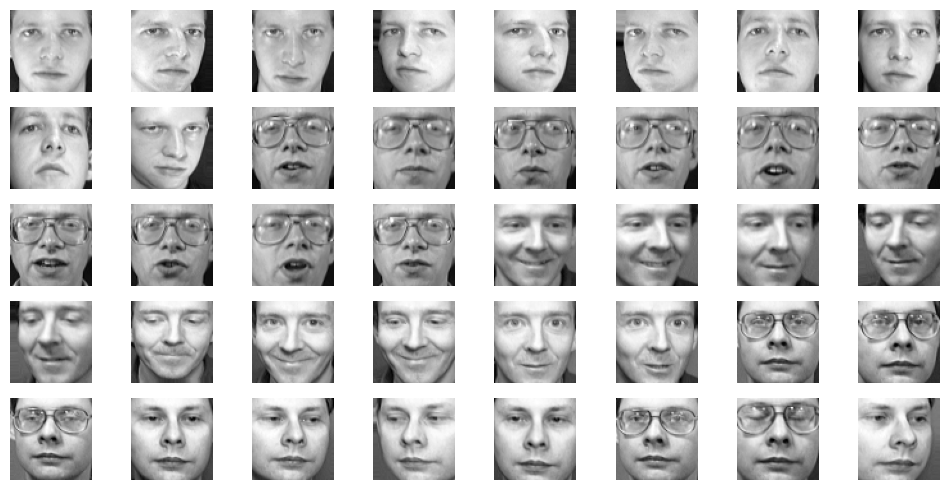

In [ ]:
# visualizzazione di alcuni campioni appartenenti alla classe positiva

plt.figure(figsize=(10, 5))
for i in range(40):
    plt.subplot(5, 8, i + 1)
    plt.imshow(positive_cl[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Dataset per la classe negativa

Per costruire la classe negativa è stato utilizzato il Linnaeus dataset, contenente immagini varie suddivise in classi. La classe che è stata scelta per la finalità del nostro progetto è la classe "other", formata da immagini rappresentanti soggetti di vario tipo, ma non volti, e la versione specifica scelta è stata quella contenente immagini 64x64, per mantenere coerenza con la clsse positiva.


Di seguito il riferimento: https://chaladze.com/l5/

In [ ]:
# dataset per la classe negativa

other_path =  '/content/gdrive/MyDrive/face_detection_negative_class_dataset/Linnaeus 5 64X64/train/other'

negative_cl = load_imgs_as_array(other_path)

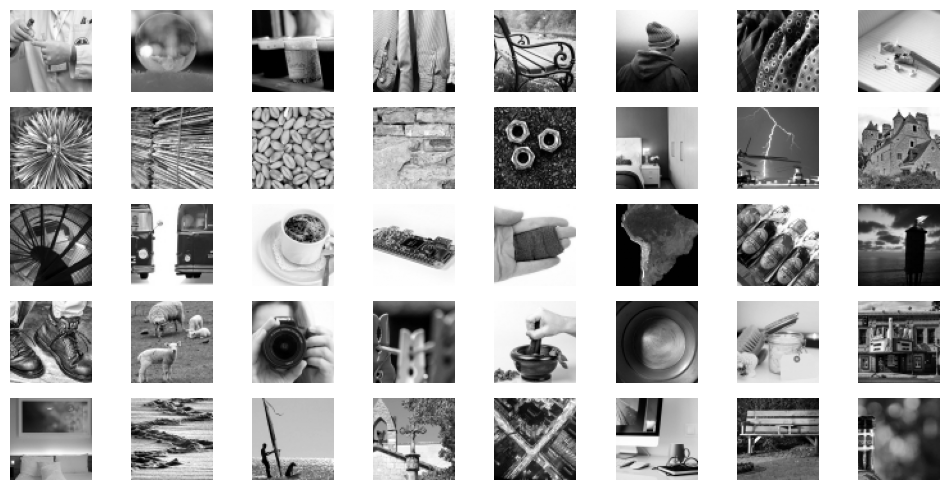

In [ ]:
# visualizzazione di alcuni campioni appartenenti alla classe negativa

plt.figure(figsize=(10, 5))
for i in range(40):
    plt.subplot(5, 8, i + 1)
    plt.imshow(negative_cl[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Pre-processing



In [ ]:
# stampo le dimensioni delle due classi

negative_cl # 1200 samples
positive_cl # 400 samples


# la classe negativa contiene più campioni, ne rimuovo alcuni per fare in modo
# che abbia la stessa dimensione della classe positiva.

negative_cl = np.array(negative_cl)
negative_cl = negative_cl[:400] # considero i primi 400 campioni
negative_cl.shape # controllo che abbia la stessa dimensione di positive_cl


(400, 64, 64)

In [ ]:
# creo dei label per indicare la classe positiva e negativa

positive_cl_labels = np.ones(len(positive_cl))
negative_cl_labels = np.zeros(len(negative_cl))

# li associo alle immagini rispettive

dataset = np.concatenate((positive_cl, negative_cl))
labels = np.concatenate((positive_cl_labels, negative_cl_labels))

# unisco dataset con labels e mischio il dataset
whole_dataset = list(zip(dataset, labels))
np.random.shuffle(whole_dataset)


In [ ]:
# converto in dataframe
df_whole_dataset = pd.DataFrame(whole_dataset, columns=['image', 'label'])
df_whole_dataset.head()


# suddiviso in features e target
X = df_whole_dataset['image'] # features
y = df_whole_dataset['label'] # target

## Creazione di una classe utile per l'estrazione delle features
Creo una classe chiamata FeatureExtractor(), da poter poi inserire all'interno della pipeline che andrà a rappresentare l'intero modello di face detection. Il metodo "transform" della classe effettua l'effettiva estrazione delle features per mezzo della histogram of oriented gradients (HOG). Di seguito i riferimenti:

-  https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#sphx-glr-download-auto-examples-features-detection-plot-hog-py


- https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog


In [ ]:
class FeatureExtractor():
    def __init__(self, pixels_per_cell=(3, 3), cells_per_block=(2, 2)):
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block

    def fit(self, X, y=None):
        return self

    def transform(self, images_list, y=None):
        features = []
        for image in images_list:
            if image.shape[0] < self.pixels_per_cell[0] * self.cells_per_block[0] or image.shape[1] < self.pixels_per_cell[1] * self.cells_per_block[1]:
                image = cv2.resize(image, (self.pixels_per_cell[1] * self.cells_per_block[1] * 2,self.pixels_per_cell[0] * self.cells_per_block[0] * 2))

            hog_features = hog(image, orientations=9, pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block, block_norm='L2-Hys',
                                visualize=False, transform_sqrt=False, feature_vector=True)
            features.append(hog_features)
        return np.array(features)



## Creazione del modello
Il modello finale, vede concatenate all'interno di una pipeline la classe FeatureExtractor() precedentemente creata e la classe StandardScaler() per andare ad effettuare una standardizzazione delle feature estratte. Come classificatore è invece stato scelto un Support Vector Classifier con kernel lineare, essendo allo stesso tempo adatto a classificazioni di immagini e non troppo costoso in termini computazionali.

In [ ]:
RANDOM_SEED = 100
face_detection = Pipeline([
    ('hog', FeatureExtractor()),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear', C=1.0, random_state=RANDOM_SEED))
  ]
)

## Applicazione della KFold validation
Applico la KFold validation per assicurarmi che le performance del modello non siano dovute a casualità, ma che si ripetano pur utilizzando diverse combinazioni per set di training e di test. In questo caso notiamo che per tutte e 5 le iterazioni il modello ha restituito delle metriche "ottime" sia per il set di training che per il set di test. Questo potrebbe portarci a sospettare overfitting, essendo il dataset utilizzato non molto grande.

In [ ]:
#inizializzo le liste che conterranno gli indici per ogni iterazione

accuracy_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
accuracy_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []

RANDOM_SEED = 100

# Kfold validation

kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    face_detection = Pipeline([
        ('hog', FeatureExtractor()),
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0, random_state= RANDOM_SEED))
      ]
    )
    face_detection.fit(X_train, y_train)
    y_pred = face_detection.predict(X_test)
    y_pred_train = face_detection.predict(X_train)


    test_list  = compute_indices(y_test, y_pred, show_definitions=False, print_values=False)
    accuracy_list_test.append(test_list[0])
    precision_list_test.append(test_list[1])
    recall_list_test.append(test_list[3])
    f1_list_test.append(test_list[2])

    train_list = compute_indices(y_train, y_pred_train, show_definitions=False, print_values=False)
    accuracy_list_train.append(train_list[0])
    precision_list_train.append(train_list[1])
    recall_list_train.append(train_list[3])
    f1_list_train.append(train_list[2])


print("TEST:")
print(f"Accuracy: {accuracy_list_test} --- Mean: {round(np.mean(accuracy_list_test),3)} --- Variance: {round(np.var(accuracy_list_test),4)}")
print(f"Precision: {precision_list_test} --- Mean: {round(np.mean(precision_list_test),3)} --- Variance: {round(np.var(precision_list_test),4)}")
print(f"Recall: {recall_list_test} --- Mean: {round(np.mean(recall_list_test),3)} --- Variance: {round(np.var(recall_list_test),4)}")
print(f"F1 score: {f1_list_test} --- Mean: {round(np.mean(f1_list_test),3)} --- Variance: {round(np.var(f1_list_test),4)}")
print("\nTRAIN:")
print(f"Accuracy: {accuracy_list_train} --- Mean: {round(np.mean(accuracy_list_train),3)} --- Variance: {round(np.var(accuracy_list_train),4)}")
print(f"Precision: {precision_list_train} --- Mean: {round(np.mean(precision_list_train),3)} --- Variance: {round(np.var(precision_list_train),4)}")
print(f"Recall: {recall_list_train} --- Mean: {round(np.mean(recall_list_train),3)} --- Variance: {round(np.var(recall_list_train),4)}")
print(f"F1 score: {f1_list_train}  --- Mean: {round(np.mean(f1_list_train),3)} --- Variance: {round(np.var(f1_list_train),4)}")

TEST:
Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
Precision: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
Recall: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
F1 score: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0

TRAIN:
Accuracy: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
Precision: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
Recall: [1.0, 1.0, 1.0, 1.0, 1.0] --- Mean: 1.0 --- Variance: 0.0
F1 score: [1.0, 1.0, 1.0, 1.0, 1.0]  --- Mean: 1.0 --- Variance: 0.0


## Definizione della funzione che permette di rilevare la presenza di un volto in un'immagine

La funzione detect_face permette di scorrere, tramite una finestra 64x64, l'immagine data in input, andando a fare una predizione ad ogni iterazione (che corrisponde allo scorrimento della finestra) di quanto contenuto nella finestra in quell'istante. La scelta della dimensione della finestra è dovuta alla risoluzione delle immagini presenti nel dataset utilizzato per l'addestramento. Per questo motivo, le immagini che vengono passate alla funzione in questione, vengono inizialmente sottoposte ad un resize di 250x250, come conseguenza della seguente assunzione: il modello dovrà essere integrato all'interno di fotocamere digitali utilizzabili per scattare principalmente dei selfie. é stato dunque scelto un rapporto di 1:4 tra la grandezza dell'eventuale volto e la totalità dell'immagine che lo contiene (essendo un selfie).



La finestra si sposta di 3 pixel alla volta in entrambe le direzioni (x e y), come compromesso per assicurare velocità di esecuzione e scansione "completa" dell'immagine. Uno step_size maggiore favorirebbe sicuramente la velocità dell'esecuzione, ma potrebbe causare una scorretta rilevazione dei volti nel caso in cui venissero accidentalmente "superati" dalla finestra tra uno step e l'altro, casistica che potrebbe verificarsi con più facilità in scatti con più persone. Per permettere più facilmente il debugging (o un'analisi più approfondita degli step eseguiti), la funzione stampa a video anche le coordinate di ogni finestra che viene analizzata ed eventualmente il volto che viene rilevato. Al termine, in caso di rilevamento, disegna un box di colore rosso sul volto e stampa il numero di volti rilevati. Si noti come è possibile che il numero di volti rilevati stampato sia maggiore alla presenza effettiva di volti nella foto: quando ciò si verifica, è dovuto con molta probabilità allo step_size, che essendo ridotto, può causare la presenza di più finestre con lo stesso volto all'interno. Per ovviare a questo problema, è stata definita anche la funzione non_max_suppression che effettua proprio la rimozione di box superflui (sulla base dello score calcolato per ognuno), qualora si sovrapponessero.





In [ ]:
def detect_face(initial_img, model, window_shape=(64, 64), threshold=0.8, step_size=3):
    """
    Esegue il face detection scorrendo l'immagine con una finestra mobile e restituendo i bounding box con punteggi.

    :param img: Immagine di input (array 2D).
    :param model: Modello di classificazione per rilevare i volti.
    :param window_shape: Dimensioni della finestra mobile (altezza, larghezza).
    :param threshold: Soglia di confidenza per considerare un volto rilevato.
    :param step_size: Passo della finestra mobile.
    :return: Bounding box e confidenze rilevate.
    """

    detected_boxes = []  # Lista dei bounding box (x_min, y_min, x_max, y_max)
    confidence_scores = []  # Lista delle confidenze

    print(f"Dimensione immagine: {initial_img.shape}")
    print(f"Dimensione finestra mobile: {window_shape}, Step Size: {step_size}")
    print(f"Soglia di rilevamento: {threshold}")

    img = cv2.resize(initial_img, (250, 250))
    print(f"Dimensione immagine post resize: {img.shape}")

    for y in range(0, img.shape[0] - window_shape[0] + 1, step_size):
        for x in range(0, img.shape[1] - window_shape[1] + 1, step_size):
            window = img[y:y + window_shape[0], x:x + window_shape[1]]

            if window.shape == (window_shape[0], window_shape[1]):  # Controllo che la finestra sia della dimensione corretta
                # Normalizzazione dell'immagine
                window = window / 255.0
                # Predizione
                prediction = model.predict([window])[0]
                print(f"Scanning window at x={x}, y={y} -> Prediction: {prediction:.2f}")

                if prediction >= threshold:
                    print(f"Face detected at x={x}, y={y} with confidence {prediction:.2f}")
                    detected_boxes.append([x, y, x + window_shape[1], y + window_shape[0]])
                    confidence_scores.append(prediction)

                    fig, ax = plt.subplots()
                    ax.imshow(window, cmap='gray')
                    plt.title(f"Detected face at x={x}, y={y}")
                    plt.show()

    print(f"Totale volti rilevati: {len(detected_boxes)}")
    return detected_boxes, confidence_scores




def non_max_suppression(boxes, scores, iou_threshold=0.3):
    """
    Applica la Non-Maximum Suppression (NMS) per eliminare i bounding box ridondanti.

    :param boxes: Lista di bounding box nel formato [x_min, y_min, x_max, y_max].
    :param scores: Lista di confidenze associate ai bounding box.
    :param iou_threshold: Soglia di IoU per eliminare i box sovrapposti.
    :return: Lista degli indici dei bounding box mantenuti.
    """
    if len(boxes) == 0:
        return []


    boxes = np.array(boxes)
    scores = np.array(scores)

    # Ordino i box in base ai punteggi di confidenza in ordine decrescente
    indices = np.argsort(scores)[::-1]

    selected_indices = []

    while len(indices) > 0:
        # Prende il box con il punteggio più alto e lo aggiuinge ai box finali
        current_index = indices[0]
        selected_indices.append(current_index)

        # calcola l'IoU tra il box scelto e gli altri rimanenti
        remaining_boxes = boxes[indices[1:]]
        chosen_box = boxes[current_index]

        x1 = np.maximum(chosen_box[0], remaining_boxes[:, 0])
        y1 = np.maximum(chosen_box[1], remaining_boxes[:, 1])
        x2 = np.minimum(chosen_box[2], remaining_boxes[:, 2])
        y2 = np.minimum(chosen_box[3], remaining_boxes[:, 3])

        # Calcola l'area di intersezione
        intersection_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

        # Calcola l'area dei box
        box_area = (chosen_box[2] - chosen_box[0]) * (chosen_box[3] - chosen_box[1])
        remaining_boxes_area = (remaining_boxes[:, 2] - remaining_boxes[:, 0]) * (remaining_boxes[:, 3] - remaining_boxes[:, 1])

        # Calcola l'IoU
        iou = intersection_area / (box_area + remaining_boxes_area - intersection_area)

        # Seleziona solo i box con IoU inferiore alla soglia
        indices = indices[1:][iou < iou_threshold]

    return selected_indices



## Test del modello su immagini varie nuove


In [ ]:
# caricamento delle immagini
photo = cv2.imread('/content/gdrive/MyDrive/test/photo_project.JPEG' , cv2.IMREAD_GRAYSCALE )

photo_2 = cv2.imread('/content/gdrive/MyDrive/test/foto_progetto_copia.jpg' , cv2.IMREAD_GRAYSCALE )

photo_3 = cv2.imread('/content/gdrive/MyDrive/test/foto.JPEG' , cv2.IMREAD_GRAYSCALE )

group = cv2.imread('/content/gdrive/MyDrive/test/amici.jpg' , cv2.IMREAD_GRAYSCALE )


Dimensione immagine: (2185, 2191)
Dimensione finestra mobile: (64, 64), Step Size: 3
Soglia di rilevamento: 0.8
Dimensione immagine post resize: (250, 250)
Scanning window at x=0, y=0 -> Prediction: 0.00
Scanning window at x=3, y=0 -> Prediction: 0.00
Scanning window at x=6, y=0 -> Prediction: 0.00
Scanning window at x=9, y=0 -> Prediction: 0.00
Scanning window at x=12, y=0 -> Prediction: 0.00
Scanning window at x=15, y=0 -> Prediction: 0.00
Scanning window at x=18, y=0 -> Prediction: 0.00
Scanning window at x=21, y=0 -> Prediction: 0.00
Scanning window at x=24, y=0 -> Prediction: 0.00
Scanning window at x=27, y=0 -> Prediction: 0.00
Scanning window at x=30, y=0 -> Prediction: 0.00
Scanning window at x=33, y=0 -> Prediction: 0.00
Scanning window at x=36, y=0 -> Prediction: 0.00
Scanning window at x=39, y=0 -> Prediction: 0.00
Scanning window at x=42, y=0 -> Prediction: 0.00
Scanning window at x=45, y=0 -> Prediction: 0.00
Scanning window at x=48, y=0 -> Prediction: 0.00
Scanning window

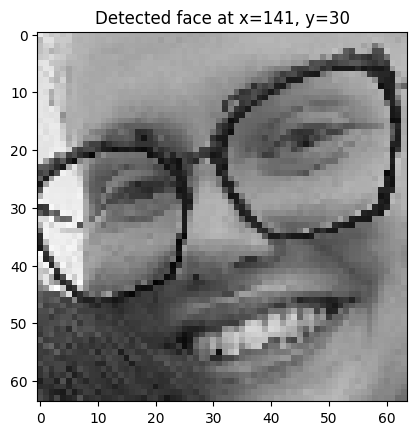

Scanning window at x=144, y=30 -> Prediction: 1.00
Face detected at x=144, y=30 with confidence 1.00


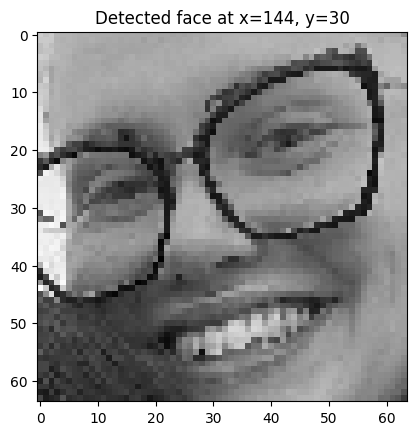

Scanning window at x=147, y=30 -> Prediction: 0.00
Scanning window at x=150, y=30 -> Prediction: 0.00
Scanning window at x=153, y=30 -> Prediction: 0.00
Scanning window at x=156, y=30 -> Prediction: 0.00
Scanning window at x=159, y=30 -> Prediction: 0.00
Scanning window at x=162, y=30 -> Prediction: 0.00
Scanning window at x=165, y=30 -> Prediction: 0.00
Scanning window at x=168, y=30 -> Prediction: 0.00
Scanning window at x=171, y=30 -> Prediction: 0.00
Scanning window at x=174, y=30 -> Prediction: 0.00
Scanning window at x=177, y=30 -> Prediction: 0.00
Scanning window at x=180, y=30 -> Prediction: 0.00
Scanning window at x=183, y=30 -> Prediction: 0.00
Scanning window at x=186, y=30 -> Prediction: 0.00
Scanning window at x=0, y=33 -> Prediction: 0.00
Scanning window at x=3, y=33 -> Prediction: 0.00
Scanning window at x=6, y=33 -> Prediction: 0.00
Scanning window at x=9, y=33 -> Prediction: 0.00
Scanning window at x=12, y=33 -> Prediction: 0.00
Scanning window at x=15, y=33 -> Predict

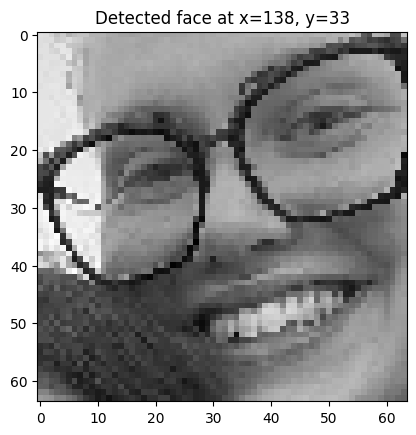

Scanning window at x=141, y=33 -> Prediction: 1.00
Face detected at x=141, y=33 with confidence 1.00


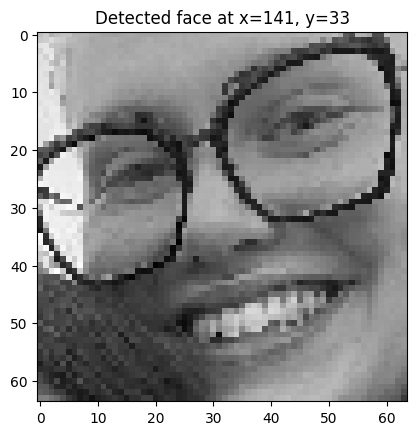

Scanning window at x=144, y=33 -> Prediction: 1.00
Face detected at x=144, y=33 with confidence 1.00


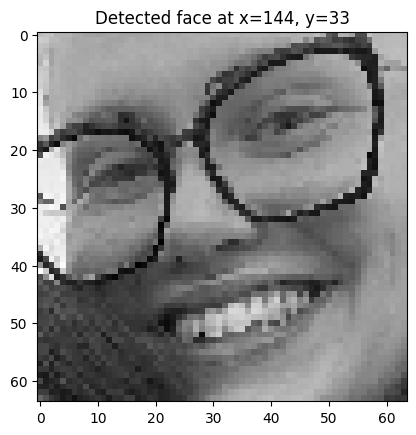

Scanning window at x=147, y=33 -> Prediction: 0.00
Scanning window at x=150, y=33 -> Prediction: 0.00
Scanning window at x=153, y=33 -> Prediction: 0.00
Scanning window at x=156, y=33 -> Prediction: 0.00
Scanning window at x=159, y=33 -> Prediction: 0.00
Scanning window at x=162, y=33 -> Prediction: 0.00
Scanning window at x=165, y=33 -> Prediction: 0.00
Scanning window at x=168, y=33 -> Prediction: 0.00
Scanning window at x=171, y=33 -> Prediction: 0.00
Scanning window at x=174, y=33 -> Prediction: 0.00
Scanning window at x=177, y=33 -> Prediction: 0.00
Scanning window at x=180, y=33 -> Prediction: 0.00
Scanning window at x=183, y=33 -> Prediction: 0.00
Scanning window at x=186, y=33 -> Prediction: 0.00
Scanning window at x=0, y=36 -> Prediction: 0.00
Scanning window at x=3, y=36 -> Prediction: 0.00
Scanning window at x=6, y=36 -> Prediction: 0.00
Scanning window at x=9, y=36 -> Prediction: 0.00
Scanning window at x=12, y=36 -> Prediction: 0.00
Scanning window at x=15, y=36 -> Predict

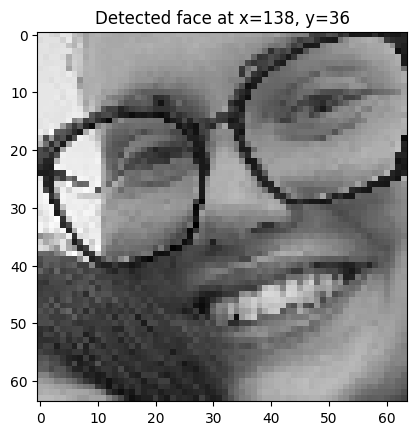

Scanning window at x=141, y=36 -> Prediction: 1.00
Face detected at x=141, y=36 with confidence 1.00


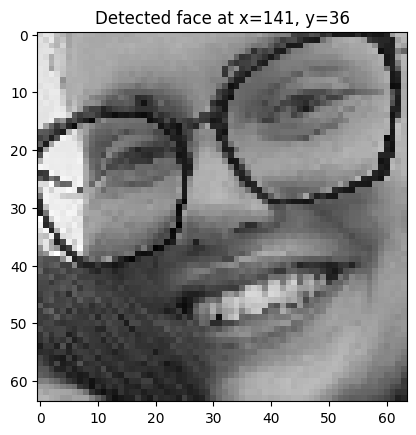

Scanning window at x=144, y=36 -> Prediction: 1.00
Face detected at x=144, y=36 with confidence 1.00


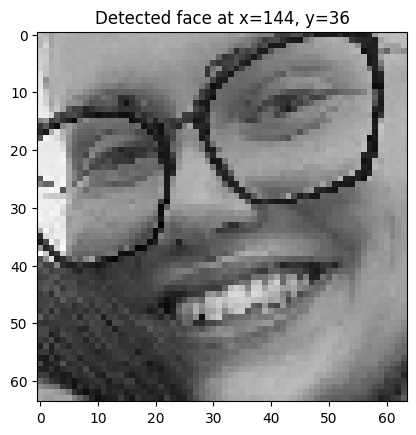

Scanning window at x=147, y=36 -> Prediction: 0.00
Scanning window at x=150, y=36 -> Prediction: 0.00
Scanning window at x=153, y=36 -> Prediction: 0.00
Scanning window at x=156, y=36 -> Prediction: 0.00
Scanning window at x=159, y=36 -> Prediction: 0.00
Scanning window at x=162, y=36 -> Prediction: 0.00
Scanning window at x=165, y=36 -> Prediction: 0.00
Scanning window at x=168, y=36 -> Prediction: 0.00
Scanning window at x=171, y=36 -> Prediction: 0.00
Scanning window at x=174, y=36 -> Prediction: 0.00
Scanning window at x=177, y=36 -> Prediction: 0.00
Scanning window at x=180, y=36 -> Prediction: 0.00
Scanning window at x=183, y=36 -> Prediction: 0.00
Scanning window at x=186, y=36 -> Prediction: 0.00
Scanning window at x=0, y=39 -> Prediction: 0.00
Scanning window at x=3, y=39 -> Prediction: 0.00
Scanning window at x=6, y=39 -> Prediction: 0.00
Scanning window at x=9, y=39 -> Prediction: 0.00
Scanning window at x=12, y=39 -> Prediction: 0.00
Scanning window at x=15, y=39 -> Predict

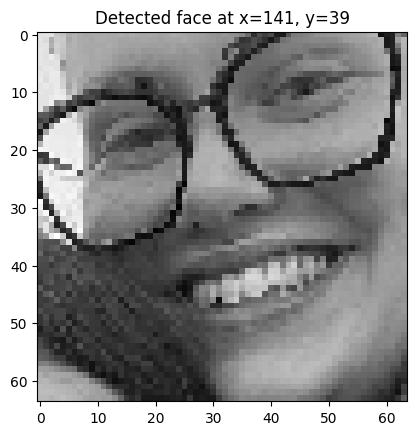

Scanning window at x=144, y=39 -> Prediction: 1.00
Face detected at x=144, y=39 with confidence 1.00


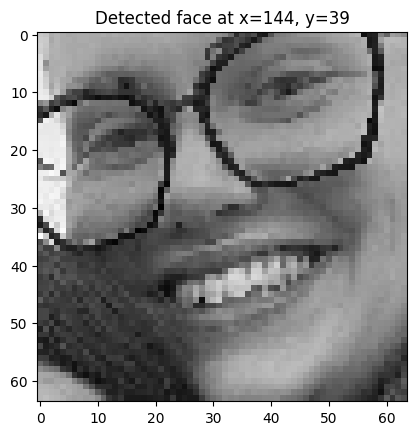

Scanning window at x=147, y=39 -> Prediction: 0.00
Scanning window at x=150, y=39 -> Prediction: 0.00
Scanning window at x=153, y=39 -> Prediction: 0.00
Scanning window at x=156, y=39 -> Prediction: 0.00
Scanning window at x=159, y=39 -> Prediction: 0.00
Scanning window at x=162, y=39 -> Prediction: 0.00
Scanning window at x=165, y=39 -> Prediction: 0.00
Scanning window at x=168, y=39 -> Prediction: 0.00
Scanning window at x=171, y=39 -> Prediction: 0.00
Scanning window at x=174, y=39 -> Prediction: 0.00
Scanning window at x=177, y=39 -> Prediction: 0.00
Scanning window at x=180, y=39 -> Prediction: 0.00
Scanning window at x=183, y=39 -> Prediction: 0.00
Scanning window at x=186, y=39 -> Prediction: 0.00
Scanning window at x=0, y=42 -> Prediction: 0.00
Scanning window at x=3, y=42 -> Prediction: 0.00
Scanning window at x=6, y=42 -> Prediction: 0.00
Scanning window at x=9, y=42 -> Prediction: 0.00
Scanning window at x=12, y=42 -> Prediction: 0.00
Scanning window at x=15, y=42 -> Predict

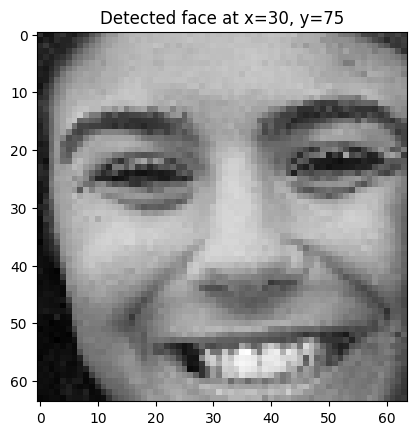

Scanning window at x=33, y=75 -> Prediction: 1.00
Face detected at x=33, y=75 with confidence 1.00


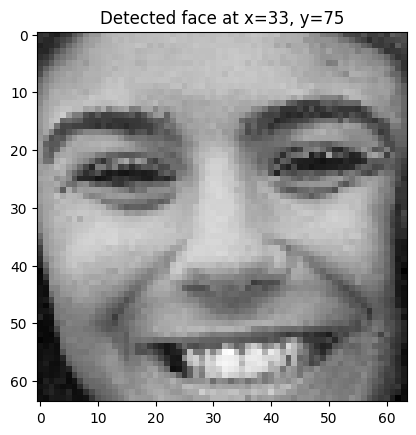

Scanning window at x=36, y=75 -> Prediction: 1.00
Face detected at x=36, y=75 with confidence 1.00


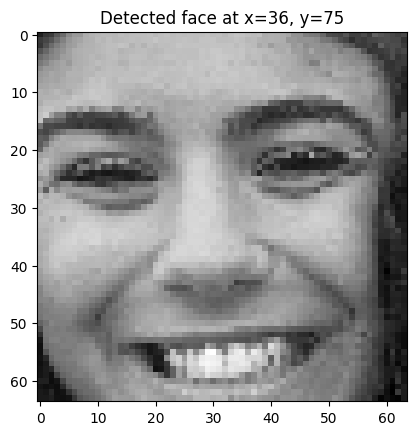

Scanning window at x=39, y=75 -> Prediction: 1.00
Face detected at x=39, y=75 with confidence 1.00


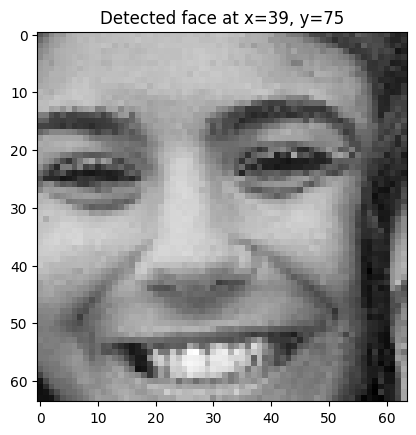

Scanning window at x=42, y=75 -> Prediction: 0.00
Scanning window at x=45, y=75 -> Prediction: 0.00
Scanning window at x=48, y=75 -> Prediction: 0.00
Scanning window at x=51, y=75 -> Prediction: 0.00
Scanning window at x=54, y=75 -> Prediction: 0.00
Scanning window at x=57, y=75 -> Prediction: 0.00
Scanning window at x=60, y=75 -> Prediction: 0.00
Scanning window at x=63, y=75 -> Prediction: 0.00
Scanning window at x=66, y=75 -> Prediction: 0.00
Scanning window at x=69, y=75 -> Prediction: 0.00
Scanning window at x=72, y=75 -> Prediction: 0.00
Scanning window at x=75, y=75 -> Prediction: 0.00
Scanning window at x=78, y=75 -> Prediction: 0.00
Scanning window at x=81, y=75 -> Prediction: 0.00
Scanning window at x=84, y=75 -> Prediction: 0.00
Scanning window at x=87, y=75 -> Prediction: 0.00
Scanning window at x=90, y=75 -> Prediction: 0.00
Scanning window at x=93, y=75 -> Prediction: 0.00
Scanning window at x=96, y=75 -> Prediction: 0.00
Scanning window at x=99, y=75 -> Prediction: 0.00


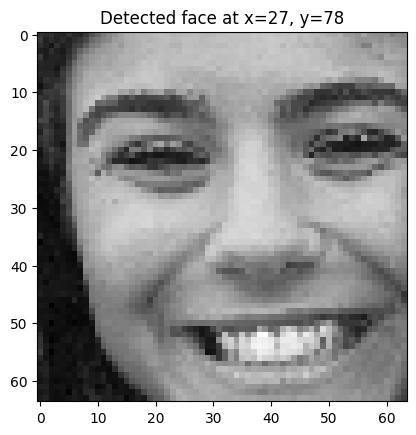

Scanning window at x=30, y=78 -> Prediction: 1.00
Face detected at x=30, y=78 with confidence 1.00


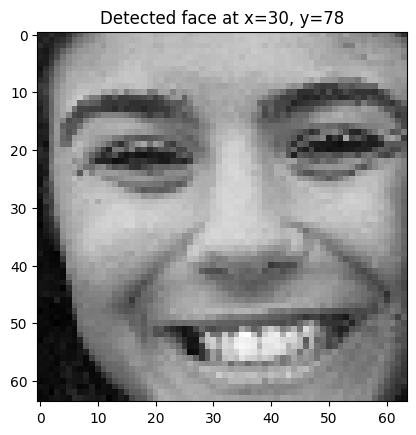

Scanning window at x=33, y=78 -> Prediction: 1.00
Face detected at x=33, y=78 with confidence 1.00


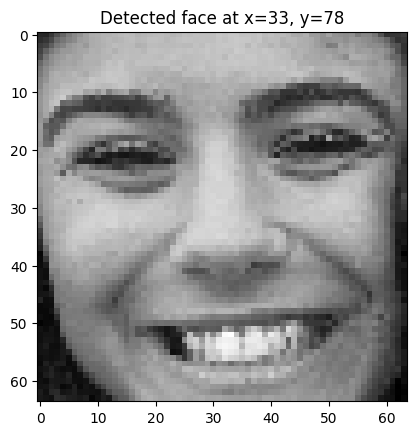

Scanning window at x=36, y=78 -> Prediction: 1.00
Face detected at x=36, y=78 with confidence 1.00


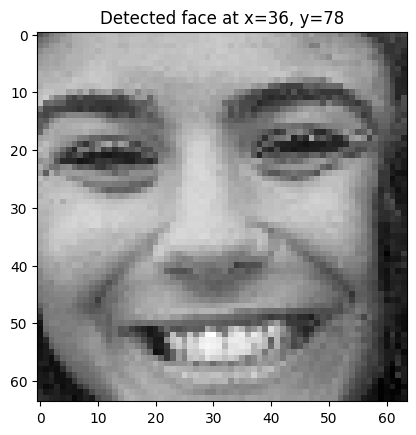

Scanning window at x=39, y=78 -> Prediction: 1.00
Face detected at x=39, y=78 with confidence 1.00


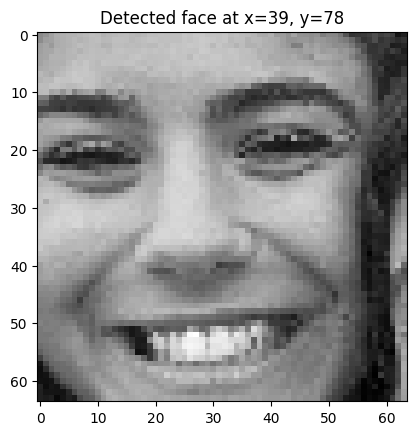

Scanning window at x=42, y=78 -> Prediction: 0.00
Scanning window at x=45, y=78 -> Prediction: 0.00
Scanning window at x=48, y=78 -> Prediction: 0.00
Scanning window at x=51, y=78 -> Prediction: 0.00
Scanning window at x=54, y=78 -> Prediction: 0.00
Scanning window at x=57, y=78 -> Prediction: 0.00
Scanning window at x=60, y=78 -> Prediction: 0.00
Scanning window at x=63, y=78 -> Prediction: 0.00
Scanning window at x=66, y=78 -> Prediction: 0.00
Scanning window at x=69, y=78 -> Prediction: 0.00
Scanning window at x=72, y=78 -> Prediction: 0.00
Scanning window at x=75, y=78 -> Prediction: 0.00
Scanning window at x=78, y=78 -> Prediction: 0.00
Scanning window at x=81, y=78 -> Prediction: 0.00
Scanning window at x=84, y=78 -> Prediction: 0.00
Scanning window at x=87, y=78 -> Prediction: 0.00
Scanning window at x=90, y=78 -> Prediction: 0.00
Scanning window at x=93, y=78 -> Prediction: 0.00
Scanning window at x=96, y=78 -> Prediction: 0.00
Scanning window at x=99, y=78 -> Prediction: 0.00


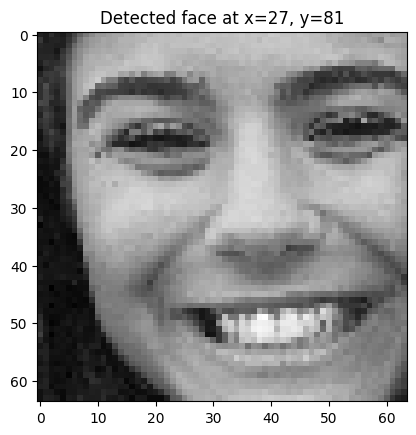

Scanning window at x=30, y=81 -> Prediction: 1.00
Face detected at x=30, y=81 with confidence 1.00


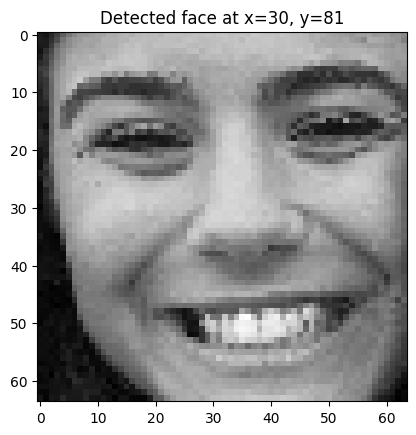

Scanning window at x=33, y=81 -> Prediction: 1.00
Face detected at x=33, y=81 with confidence 1.00


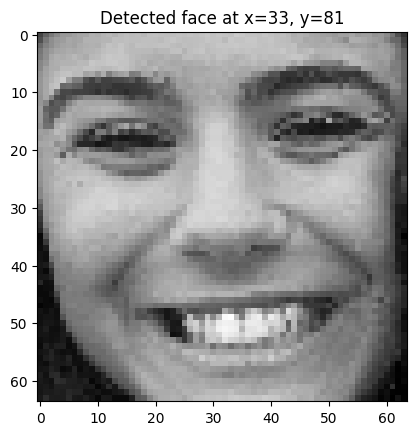

Scanning window at x=36, y=81 -> Prediction: 1.00
Face detected at x=36, y=81 with confidence 1.00


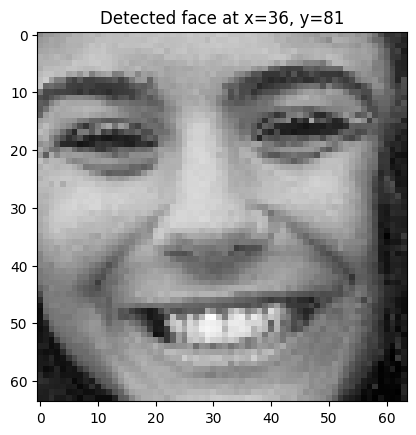

Scanning window at x=39, y=81 -> Prediction: 1.00
Face detected at x=39, y=81 with confidence 1.00


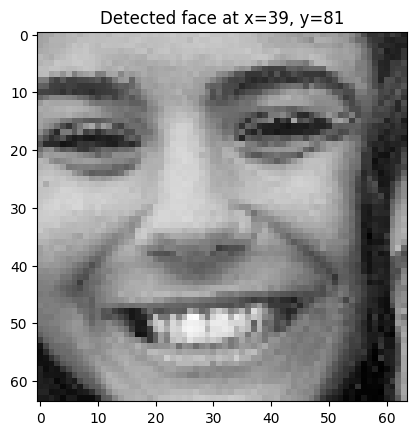

Scanning window at x=42, y=81 -> Prediction: 0.00
Scanning window at x=45, y=81 -> Prediction: 0.00
Scanning window at x=48, y=81 -> Prediction: 0.00
Scanning window at x=51, y=81 -> Prediction: 0.00
Scanning window at x=54, y=81 -> Prediction: 0.00
Scanning window at x=57, y=81 -> Prediction: 0.00
Scanning window at x=60, y=81 -> Prediction: 0.00
Scanning window at x=63, y=81 -> Prediction: 0.00
Scanning window at x=66, y=81 -> Prediction: 0.00
Scanning window at x=69, y=81 -> Prediction: 0.00
Scanning window at x=72, y=81 -> Prediction: 0.00
Scanning window at x=75, y=81 -> Prediction: 0.00
Scanning window at x=78, y=81 -> Prediction: 0.00
Scanning window at x=81, y=81 -> Prediction: 0.00
Scanning window at x=84, y=81 -> Prediction: 0.00
Scanning window at x=87, y=81 -> Prediction: 0.00
Scanning window at x=90, y=81 -> Prediction: 0.00
Scanning window at x=93, y=81 -> Prediction: 0.00
Scanning window at x=96, y=81 -> Prediction: 0.00
Scanning window at x=99, y=81 -> Prediction: 0.00


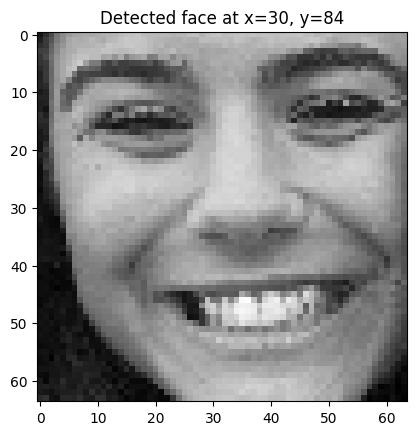

Scanning window at x=33, y=84 -> Prediction: 1.00
Face detected at x=33, y=84 with confidence 1.00


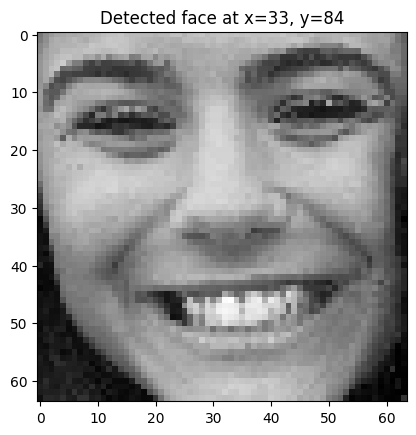

Scanning window at x=36, y=84 -> Prediction: 1.00
Face detected at x=36, y=84 with confidence 1.00


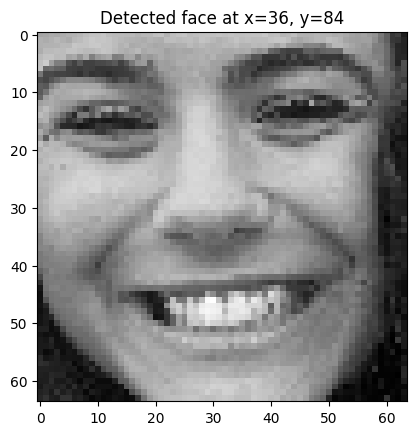

Scanning window at x=39, y=84 -> Prediction: 0.00
Scanning window at x=42, y=84 -> Prediction: 0.00
Scanning window at x=45, y=84 -> Prediction: 0.00
Scanning window at x=48, y=84 -> Prediction: 0.00
Scanning window at x=51, y=84 -> Prediction: 0.00
Scanning window at x=54, y=84 -> Prediction: 0.00
Scanning window at x=57, y=84 -> Prediction: 0.00
Scanning window at x=60, y=84 -> Prediction: 0.00
Scanning window at x=63, y=84 -> Prediction: 0.00
Scanning window at x=66, y=84 -> Prediction: 0.00
Scanning window at x=69, y=84 -> Prediction: 0.00
Scanning window at x=72, y=84 -> Prediction: 0.00
Scanning window at x=75, y=84 -> Prediction: 0.00
Scanning window at x=78, y=84 -> Prediction: 0.00
Scanning window at x=81, y=84 -> Prediction: 0.00
Scanning window at x=84, y=84 -> Prediction: 0.00
Scanning window at x=87, y=84 -> Prediction: 0.00
Scanning window at x=90, y=84 -> Prediction: 0.00
Scanning window at x=93, y=84 -> Prediction: 0.00
Scanning window at x=96, y=84 -> Prediction: 0.00


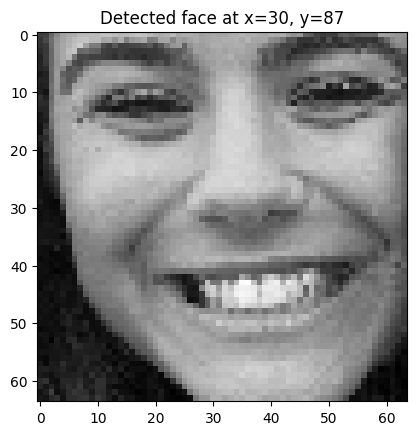

Scanning window at x=33, y=87 -> Prediction: 1.00
Face detected at x=33, y=87 with confidence 1.00


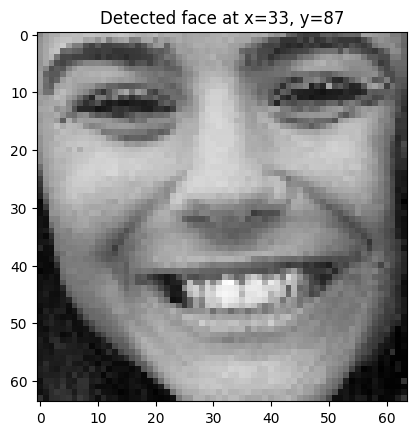

Scanning window at x=36, y=87 -> Prediction: 1.00
Face detected at x=36, y=87 with confidence 1.00


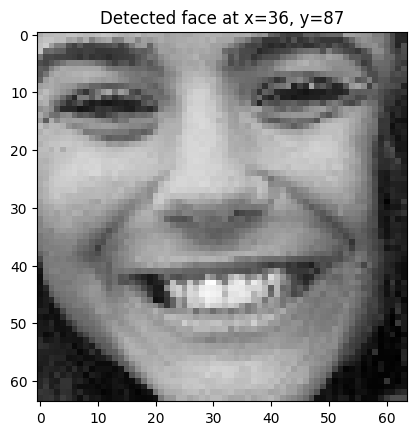

Scanning window at x=39, y=87 -> Prediction: 0.00
Scanning window at x=42, y=87 -> Prediction: 0.00
Scanning window at x=45, y=87 -> Prediction: 0.00
Scanning window at x=48, y=87 -> Prediction: 0.00
Scanning window at x=51, y=87 -> Prediction: 0.00
Scanning window at x=54, y=87 -> Prediction: 0.00
Scanning window at x=57, y=87 -> Prediction: 0.00
Scanning window at x=60, y=87 -> Prediction: 0.00
Scanning window at x=63, y=87 -> Prediction: 0.00
Scanning window at x=66, y=87 -> Prediction: 0.00
Scanning window at x=69, y=87 -> Prediction: 0.00
Scanning window at x=72, y=87 -> Prediction: 0.00
Scanning window at x=75, y=87 -> Prediction: 0.00
Scanning window at x=78, y=87 -> Prediction: 0.00
Scanning window at x=81, y=87 -> Prediction: 0.00
Scanning window at x=84, y=87 -> Prediction: 0.00
Scanning window at x=87, y=87 -> Prediction: 0.00
Scanning window at x=90, y=87 -> Prediction: 0.00
Scanning window at x=93, y=87 -> Prediction: 0.00
Scanning window at x=96, y=87 -> Prediction: 0.00


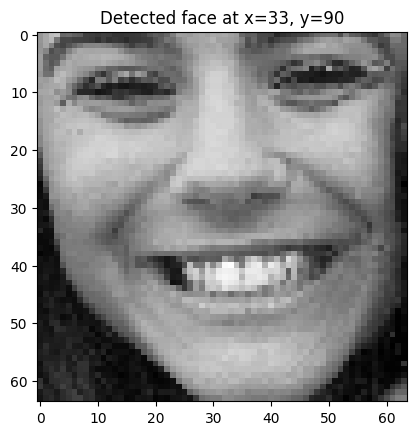

Scanning window at x=36, y=90 -> Prediction: 0.00
Scanning window at x=39, y=90 -> Prediction: 0.00
Scanning window at x=42, y=90 -> Prediction: 0.00
Scanning window at x=45, y=90 -> Prediction: 0.00
Scanning window at x=48, y=90 -> Prediction: 0.00
Scanning window at x=51, y=90 -> Prediction: 0.00
Scanning window at x=54, y=90 -> Prediction: 0.00
Scanning window at x=57, y=90 -> Prediction: 0.00
Scanning window at x=60, y=90 -> Prediction: 0.00
Scanning window at x=63, y=90 -> Prediction: 0.00
Scanning window at x=66, y=90 -> Prediction: 0.00
Scanning window at x=69, y=90 -> Prediction: 0.00
Scanning window at x=72, y=90 -> Prediction: 0.00
Scanning window at x=75, y=90 -> Prediction: 0.00
Scanning window at x=78, y=90 -> Prediction: 0.00
Scanning window at x=81, y=90 -> Prediction: 0.00
Scanning window at x=84, y=90 -> Prediction: 0.00
Scanning window at x=87, y=90 -> Prediction: 0.00
Scanning window at x=90, y=90 -> Prediction: 0.00
Scanning window at x=93, y=90 -> Prediction: 0.00


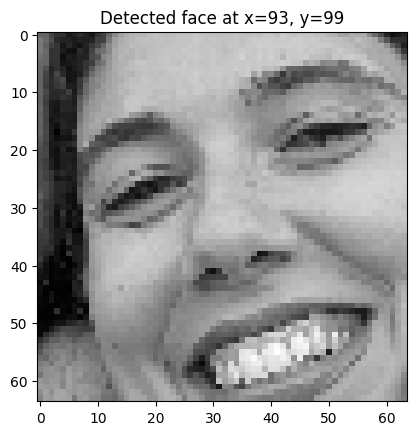

Scanning window at x=96, y=99 -> Prediction: 1.00
Face detected at x=96, y=99 with confidence 1.00


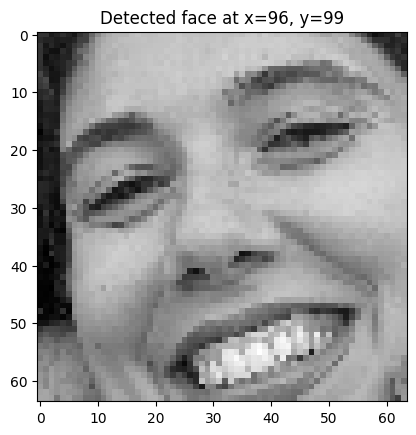

Scanning window at x=99, y=99 -> Prediction: 1.00
Face detected at x=99, y=99 with confidence 1.00


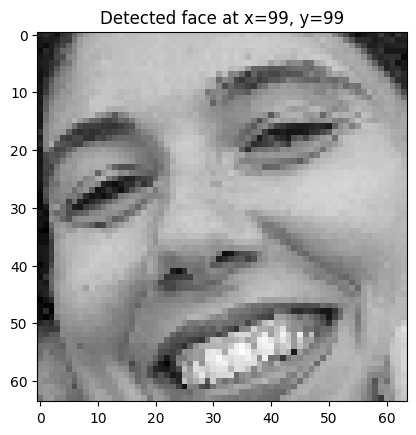

Scanning window at x=102, y=99 -> Prediction: 0.00
Scanning window at x=105, y=99 -> Prediction: 0.00
Scanning window at x=108, y=99 -> Prediction: 0.00
Scanning window at x=111, y=99 -> Prediction: 0.00
Scanning window at x=114, y=99 -> Prediction: 0.00
Scanning window at x=117, y=99 -> Prediction: 0.00
Scanning window at x=120, y=99 -> Prediction: 0.00
Scanning window at x=123, y=99 -> Prediction: 0.00
Scanning window at x=126, y=99 -> Prediction: 0.00
Scanning window at x=129, y=99 -> Prediction: 0.00
Scanning window at x=132, y=99 -> Prediction: 0.00
Scanning window at x=135, y=99 -> Prediction: 0.00
Scanning window at x=138, y=99 -> Prediction: 0.00
Scanning window at x=141, y=99 -> Prediction: 0.00
Scanning window at x=144, y=99 -> Prediction: 0.00
Scanning window at x=147, y=99 -> Prediction: 0.00
Scanning window at x=150, y=99 -> Prediction: 0.00
Scanning window at x=153, y=99 -> Prediction: 0.00
Scanning window at x=156, y=99 -> Prediction: 0.00
Scanning window at x=159, y=99 

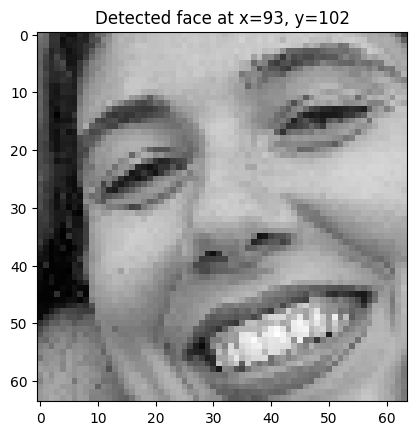

Scanning window at x=96, y=102 -> Prediction: 1.00
Face detected at x=96, y=102 with confidence 1.00


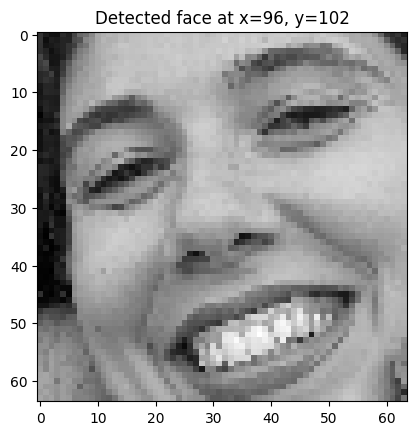

Scanning window at x=99, y=102 -> Prediction: 1.00
Face detected at x=99, y=102 with confidence 1.00


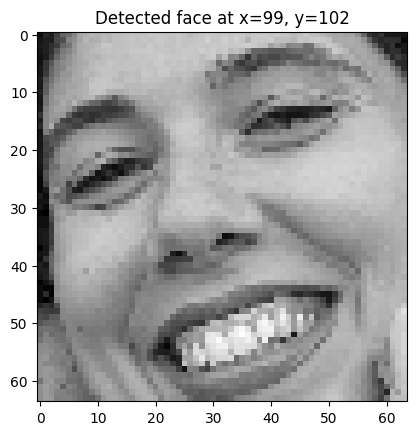

Scanning window at x=102, y=102 -> Prediction: 0.00
Scanning window at x=105, y=102 -> Prediction: 0.00
Scanning window at x=108, y=102 -> Prediction: 0.00
Scanning window at x=111, y=102 -> Prediction: 0.00
Scanning window at x=114, y=102 -> Prediction: 0.00
Scanning window at x=117, y=102 -> Prediction: 0.00
Scanning window at x=120, y=102 -> Prediction: 0.00
Scanning window at x=123, y=102 -> Prediction: 0.00
Scanning window at x=126, y=102 -> Prediction: 0.00
Scanning window at x=129, y=102 -> Prediction: 0.00
Scanning window at x=132, y=102 -> Prediction: 0.00
Scanning window at x=135, y=102 -> Prediction: 0.00
Scanning window at x=138, y=102 -> Prediction: 0.00
Scanning window at x=141, y=102 -> Prediction: 0.00
Scanning window at x=144, y=102 -> Prediction: 0.00
Scanning window at x=147, y=102 -> Prediction: 0.00
Scanning window at x=150, y=102 -> Prediction: 0.00
Scanning window at x=153, y=102 -> Prediction: 0.00
Scanning window at x=156, y=102 -> Prediction: 0.00
Scanning win

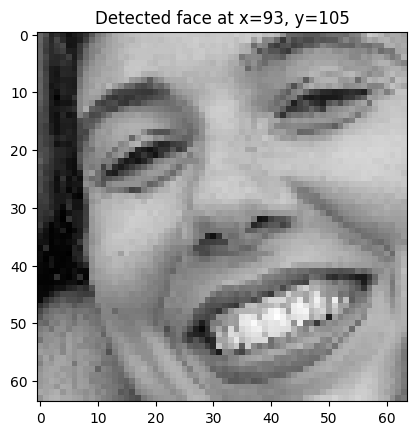

Scanning window at x=96, y=105 -> Prediction: 1.00
Face detected at x=96, y=105 with confidence 1.00


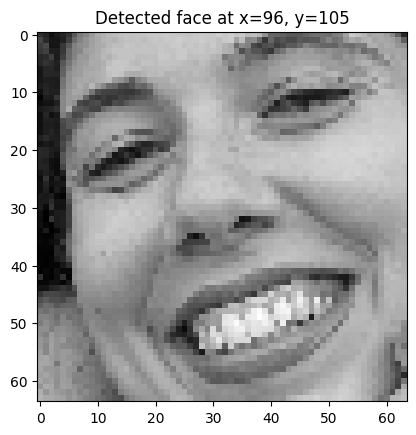

Scanning window at x=99, y=105 -> Prediction: 1.00
Face detected at x=99, y=105 with confidence 1.00


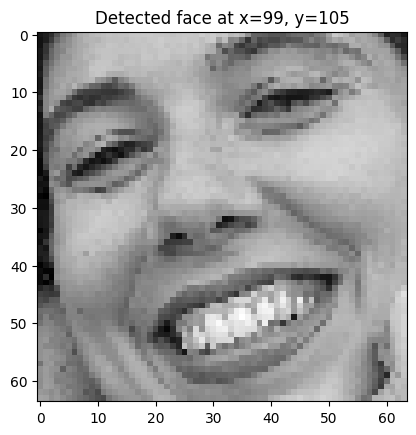

Scanning window at x=102, y=105 -> Prediction: 0.00
Scanning window at x=105, y=105 -> Prediction: 0.00
Scanning window at x=108, y=105 -> Prediction: 0.00
Scanning window at x=111, y=105 -> Prediction: 0.00
Scanning window at x=114, y=105 -> Prediction: 0.00
Scanning window at x=117, y=105 -> Prediction: 0.00
Scanning window at x=120, y=105 -> Prediction: 0.00
Scanning window at x=123, y=105 -> Prediction: 0.00
Scanning window at x=126, y=105 -> Prediction: 0.00
Scanning window at x=129, y=105 -> Prediction: 0.00
Scanning window at x=132, y=105 -> Prediction: 0.00
Scanning window at x=135, y=105 -> Prediction: 0.00
Scanning window at x=138, y=105 -> Prediction: 0.00
Scanning window at x=141, y=105 -> Prediction: 0.00
Scanning window at x=144, y=105 -> Prediction: 0.00
Scanning window at x=147, y=105 -> Prediction: 0.00
Scanning window at x=150, y=105 -> Prediction: 0.00
Scanning window at x=153, y=105 -> Prediction: 0.00
Scanning window at x=156, y=105 -> Prediction: 0.00
Scanning win

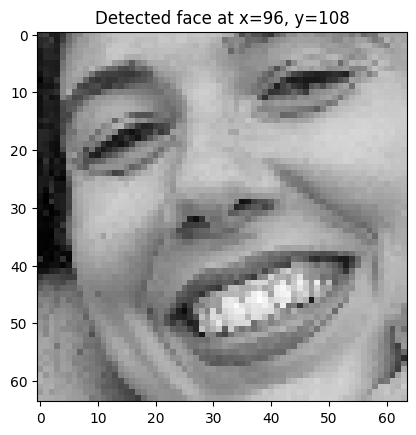

Scanning window at x=99, y=108 -> Prediction: 1.00
Face detected at x=99, y=108 with confidence 1.00


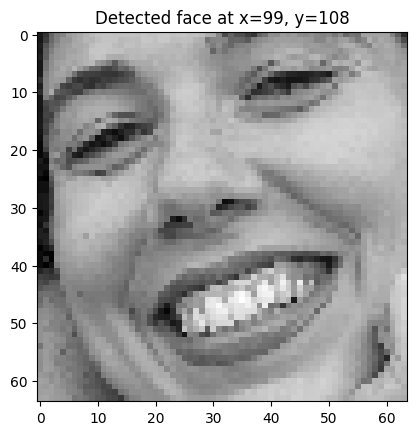

Scanning window at x=102, y=108 -> Prediction: 0.00
Scanning window at x=105, y=108 -> Prediction: 0.00
Scanning window at x=108, y=108 -> Prediction: 0.00
Scanning window at x=111, y=108 -> Prediction: 0.00
Scanning window at x=114, y=108 -> Prediction: 0.00
Scanning window at x=117, y=108 -> Prediction: 0.00
Scanning window at x=120, y=108 -> Prediction: 0.00
Scanning window at x=123, y=108 -> Prediction: 0.00
Scanning window at x=126, y=108 -> Prediction: 0.00
Scanning window at x=129, y=108 -> Prediction: 0.00
Scanning window at x=132, y=108 -> Prediction: 0.00
Scanning window at x=135, y=108 -> Prediction: 0.00
Scanning window at x=138, y=108 -> Prediction: 0.00
Scanning window at x=141, y=108 -> Prediction: 0.00
Scanning window at x=144, y=108 -> Prediction: 0.00
Scanning window at x=147, y=108 -> Prediction: 0.00
Scanning window at x=150, y=108 -> Prediction: 0.00
Scanning window at x=153, y=108 -> Prediction: 0.00
Scanning window at x=156, y=108 -> Prediction: 0.00
Scanning win

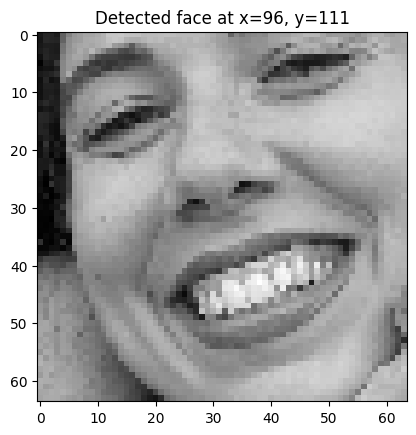

Scanning window at x=99, y=111 -> Prediction: 1.00
Face detected at x=99, y=111 with confidence 1.00


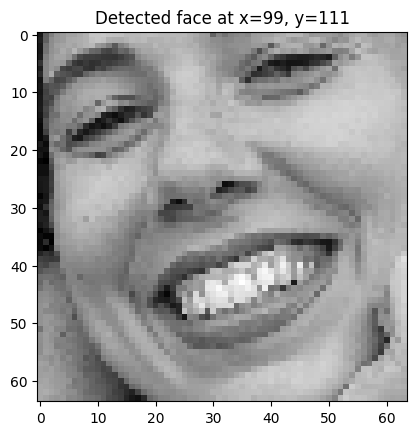

Scanning window at x=102, y=111 -> Prediction: 0.00
Scanning window at x=105, y=111 -> Prediction: 0.00
Scanning window at x=108, y=111 -> Prediction: 0.00
Scanning window at x=111, y=111 -> Prediction: 0.00
Scanning window at x=114, y=111 -> Prediction: 0.00
Scanning window at x=117, y=111 -> Prediction: 0.00
Scanning window at x=120, y=111 -> Prediction: 0.00
Scanning window at x=123, y=111 -> Prediction: 0.00
Scanning window at x=126, y=111 -> Prediction: 0.00
Scanning window at x=129, y=111 -> Prediction: 0.00
Scanning window at x=132, y=111 -> Prediction: 0.00
Scanning window at x=135, y=111 -> Prediction: 0.00
Scanning window at x=138, y=111 -> Prediction: 0.00
Scanning window at x=141, y=111 -> Prediction: 0.00
Scanning window at x=144, y=111 -> Prediction: 0.00
Scanning window at x=147, y=111 -> Prediction: 0.00
Scanning window at x=150, y=111 -> Prediction: 0.00
Scanning window at x=153, y=111 -> Prediction: 0.00
Scanning window at x=156, y=111 -> Prediction: 0.00
Scanning win

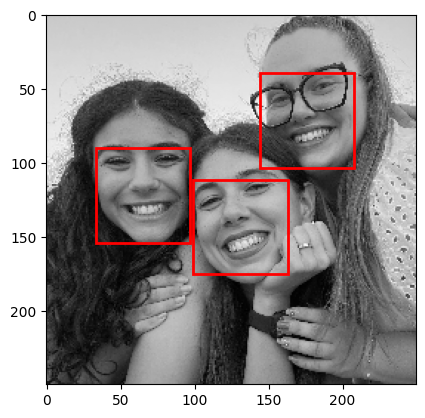

In [ ]:
#face detection
boxes, scores = detect_face(group, face_detection)

#  Non-Maximum Suppression
selected_indices = non_max_suppression(boxes, scores)
filtered_boxes = [boxes[i] for i in selected_indices]

ax = plt.gca()
ax.imshow(cv2.resize(group, (250, 250)), cmap='gray')

for box in filtered_boxes:
    rect = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', linewidth=2, facecolor='none')
    ax.add_patch(rect)

plt.show()

Dimensione immagine: (2781, 2877)
Dimensione finestra mobile: (64, 64), Step Size: 3
Soglia di rilevamento: 0.8
Dimensione immagine post resize: (250, 250)
Scanning window at x=0, y=0 -> Prediction: 0.00
Scanning window at x=3, y=0 -> Prediction: 0.00
Scanning window at x=6, y=0 -> Prediction: 0.00
Scanning window at x=9, y=0 -> Prediction: 0.00
Scanning window at x=12, y=0 -> Prediction: 0.00
Scanning window at x=15, y=0 -> Prediction: 0.00
Scanning window at x=18, y=0 -> Prediction: 0.00
Scanning window at x=21, y=0 -> Prediction: 0.00
Scanning window at x=24, y=0 -> Prediction: 0.00
Scanning window at x=27, y=0 -> Prediction: 0.00
Scanning window at x=30, y=0 -> Prediction: 0.00
Scanning window at x=33, y=0 -> Prediction: 0.00
Scanning window at x=36, y=0 -> Prediction: 0.00
Scanning window at x=39, y=0 -> Prediction: 0.00
Scanning window at x=42, y=0 -> Prediction: 0.00
Scanning window at x=45, y=0 -> Prediction: 0.00
Scanning window at x=48, y=0 -> Prediction: 0.00
Scanning window

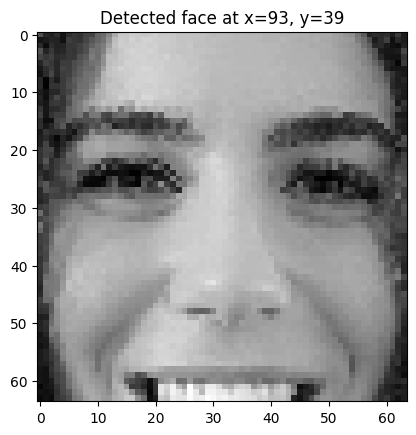

Scanning window at x=96, y=39 -> Prediction: 1.00
Face detected at x=96, y=39 with confidence 1.00


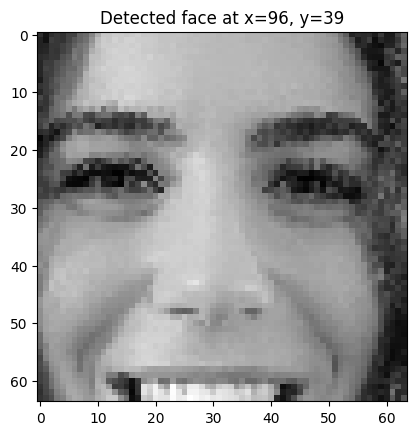

Scanning window at x=99, y=39 -> Prediction: 0.00
Scanning window at x=102, y=39 -> Prediction: 0.00
Scanning window at x=105, y=39 -> Prediction: 0.00
Scanning window at x=108, y=39 -> Prediction: 0.00
Scanning window at x=111, y=39 -> Prediction: 0.00
Scanning window at x=114, y=39 -> Prediction: 0.00
Scanning window at x=117, y=39 -> Prediction: 0.00
Scanning window at x=120, y=39 -> Prediction: 0.00
Scanning window at x=123, y=39 -> Prediction: 0.00
Scanning window at x=126, y=39 -> Prediction: 0.00
Scanning window at x=129, y=39 -> Prediction: 0.00
Scanning window at x=132, y=39 -> Prediction: 0.00
Scanning window at x=135, y=39 -> Prediction: 0.00
Scanning window at x=138, y=39 -> Prediction: 0.00
Scanning window at x=141, y=39 -> Prediction: 0.00
Scanning window at x=144, y=39 -> Prediction: 0.00
Scanning window at x=147, y=39 -> Prediction: 0.00
Scanning window at x=150, y=39 -> Prediction: 0.00
Scanning window at x=153, y=39 -> Prediction: 0.00
Scanning window at x=156, y=39 -

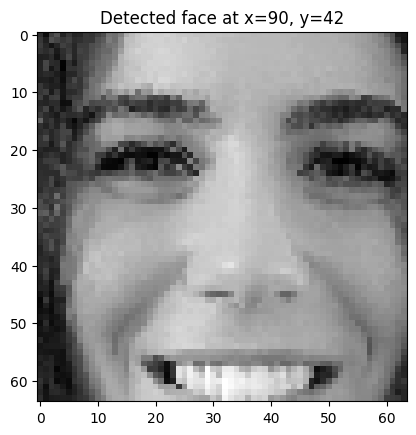

Scanning window at x=93, y=42 -> Prediction: 1.00
Face detected at x=93, y=42 with confidence 1.00


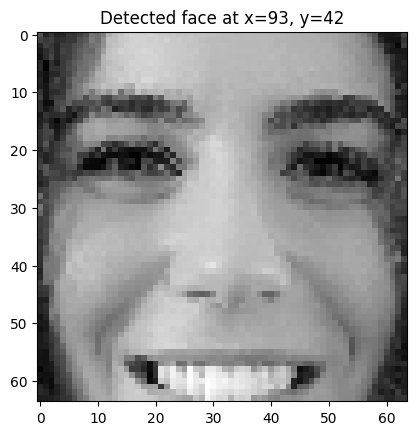

Scanning window at x=96, y=42 -> Prediction: 1.00
Face detected at x=96, y=42 with confidence 1.00


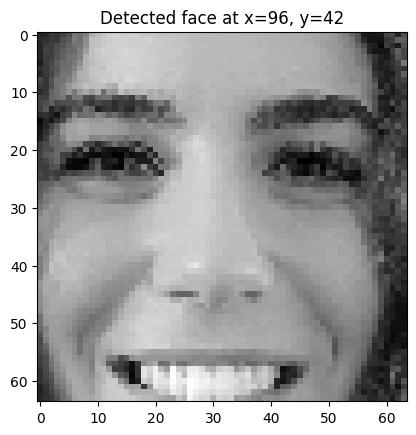

Scanning window at x=99, y=42 -> Prediction: 1.00
Face detected at x=99, y=42 with confidence 1.00


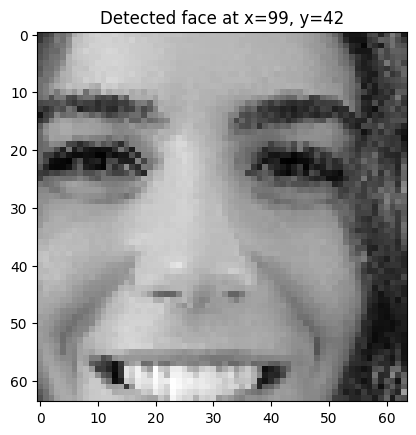

Scanning window at x=102, y=42 -> Prediction: 0.00
Scanning window at x=105, y=42 -> Prediction: 0.00
Scanning window at x=108, y=42 -> Prediction: 0.00
Scanning window at x=111, y=42 -> Prediction: 0.00
Scanning window at x=114, y=42 -> Prediction: 0.00
Scanning window at x=117, y=42 -> Prediction: 0.00
Scanning window at x=120, y=42 -> Prediction: 0.00
Scanning window at x=123, y=42 -> Prediction: 0.00
Scanning window at x=126, y=42 -> Prediction: 0.00
Scanning window at x=129, y=42 -> Prediction: 0.00
Scanning window at x=132, y=42 -> Prediction: 0.00
Scanning window at x=135, y=42 -> Prediction: 0.00
Scanning window at x=138, y=42 -> Prediction: 0.00
Scanning window at x=141, y=42 -> Prediction: 0.00
Scanning window at x=144, y=42 -> Prediction: 0.00
Scanning window at x=147, y=42 -> Prediction: 0.00
Scanning window at x=150, y=42 -> Prediction: 0.00
Scanning window at x=153, y=42 -> Prediction: 0.00
Scanning window at x=156, y=42 -> Prediction: 0.00
Scanning window at x=159, y=42 

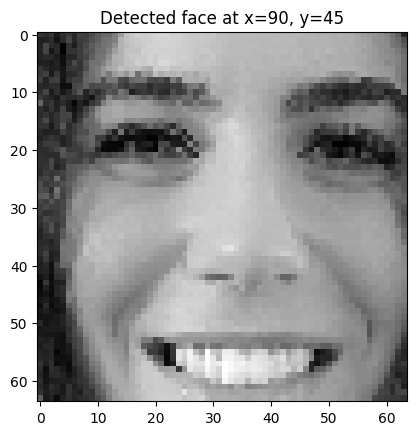

Scanning window at x=93, y=45 -> Prediction: 1.00
Face detected at x=93, y=45 with confidence 1.00


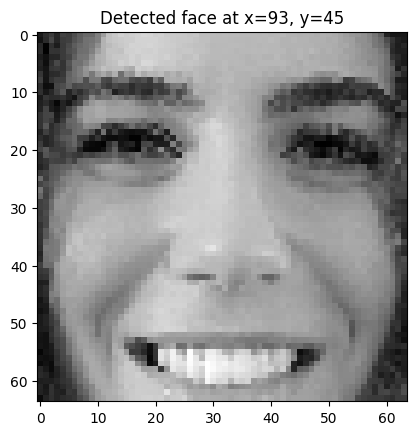

Scanning window at x=96, y=45 -> Prediction: 1.00
Face detected at x=96, y=45 with confidence 1.00


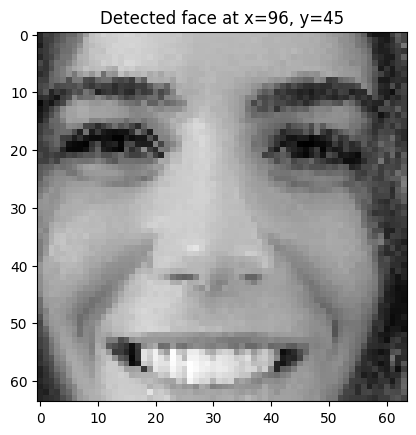

Scanning window at x=99, y=45 -> Prediction: 1.00
Face detected at x=99, y=45 with confidence 1.00


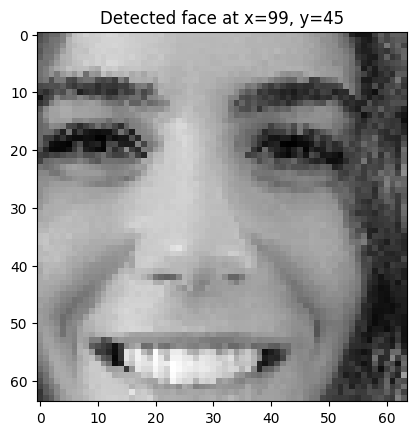

Scanning window at x=102, y=45 -> Prediction: 0.00
Scanning window at x=105, y=45 -> Prediction: 0.00
Scanning window at x=108, y=45 -> Prediction: 0.00
Scanning window at x=111, y=45 -> Prediction: 0.00
Scanning window at x=114, y=45 -> Prediction: 0.00
Scanning window at x=117, y=45 -> Prediction: 0.00
Scanning window at x=120, y=45 -> Prediction: 0.00
Scanning window at x=123, y=45 -> Prediction: 0.00
Scanning window at x=126, y=45 -> Prediction: 0.00
Scanning window at x=129, y=45 -> Prediction: 0.00
Scanning window at x=132, y=45 -> Prediction: 0.00
Scanning window at x=135, y=45 -> Prediction: 0.00
Scanning window at x=138, y=45 -> Prediction: 0.00
Scanning window at x=141, y=45 -> Prediction: 0.00
Scanning window at x=144, y=45 -> Prediction: 0.00
Scanning window at x=147, y=45 -> Prediction: 0.00
Scanning window at x=150, y=45 -> Prediction: 0.00
Scanning window at x=153, y=45 -> Prediction: 0.00
Scanning window at x=156, y=45 -> Prediction: 0.00
Scanning window at x=159, y=45 

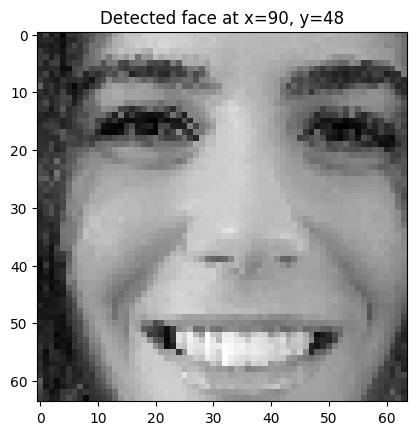

Scanning window at x=93, y=48 -> Prediction: 1.00
Face detected at x=93, y=48 with confidence 1.00


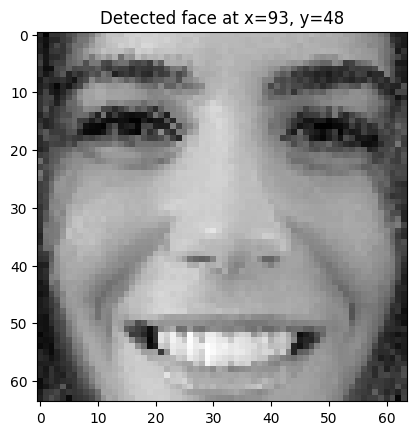

Scanning window at x=96, y=48 -> Prediction: 1.00
Face detected at x=96, y=48 with confidence 1.00


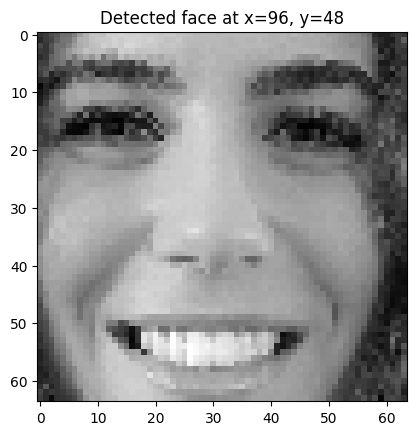

Scanning window at x=99, y=48 -> Prediction: 1.00
Face detected at x=99, y=48 with confidence 1.00


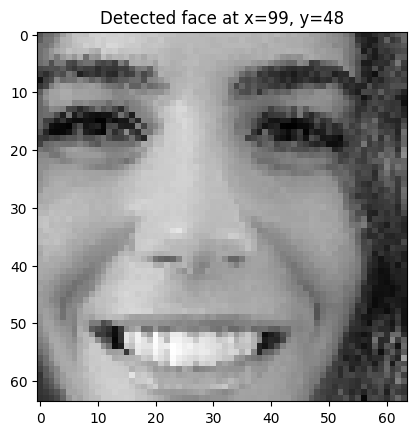

Scanning window at x=102, y=48 -> Prediction: 0.00
Scanning window at x=105, y=48 -> Prediction: 0.00
Scanning window at x=108, y=48 -> Prediction: 0.00
Scanning window at x=111, y=48 -> Prediction: 0.00
Scanning window at x=114, y=48 -> Prediction: 0.00
Scanning window at x=117, y=48 -> Prediction: 0.00
Scanning window at x=120, y=48 -> Prediction: 0.00
Scanning window at x=123, y=48 -> Prediction: 0.00
Scanning window at x=126, y=48 -> Prediction: 0.00
Scanning window at x=129, y=48 -> Prediction: 0.00
Scanning window at x=132, y=48 -> Prediction: 0.00
Scanning window at x=135, y=48 -> Prediction: 0.00
Scanning window at x=138, y=48 -> Prediction: 0.00
Scanning window at x=141, y=48 -> Prediction: 0.00
Scanning window at x=144, y=48 -> Prediction: 0.00
Scanning window at x=147, y=48 -> Prediction: 0.00
Scanning window at x=150, y=48 -> Prediction: 0.00
Scanning window at x=153, y=48 -> Prediction: 0.00
Scanning window at x=156, y=48 -> Prediction: 0.00
Scanning window at x=159, y=48 

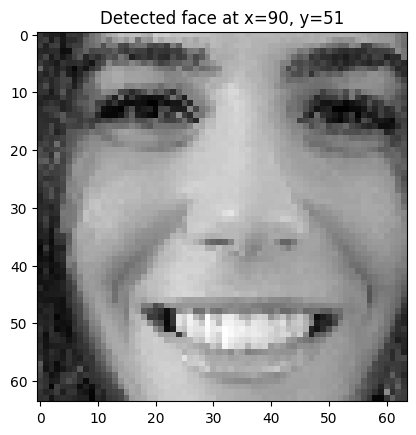

Scanning window at x=93, y=51 -> Prediction: 1.00
Face detected at x=93, y=51 with confidence 1.00


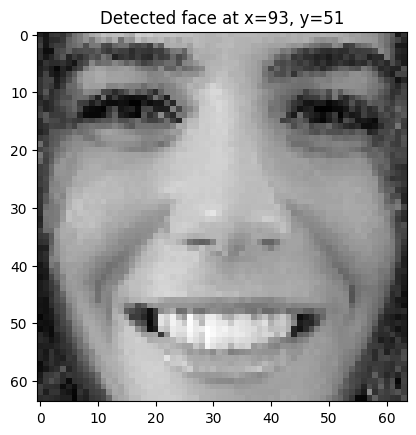

Scanning window at x=96, y=51 -> Prediction: 1.00
Face detected at x=96, y=51 with confidence 1.00


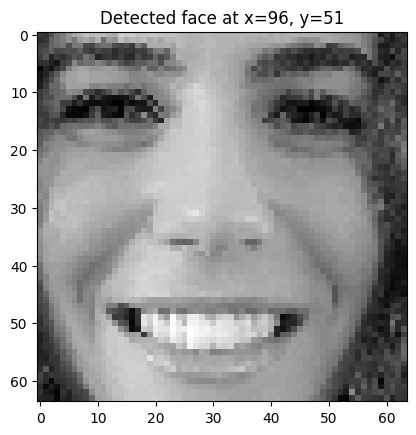

Scanning window at x=99, y=51 -> Prediction: 1.00
Face detected at x=99, y=51 with confidence 1.00


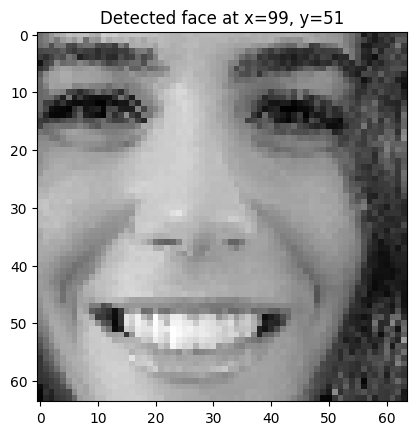

Scanning window at x=102, y=51 -> Prediction: 0.00
Scanning window at x=105, y=51 -> Prediction: 0.00
Scanning window at x=108, y=51 -> Prediction: 0.00
Scanning window at x=111, y=51 -> Prediction: 0.00
Scanning window at x=114, y=51 -> Prediction: 0.00
Scanning window at x=117, y=51 -> Prediction: 0.00
Scanning window at x=120, y=51 -> Prediction: 0.00
Scanning window at x=123, y=51 -> Prediction: 0.00
Scanning window at x=126, y=51 -> Prediction: 0.00
Scanning window at x=129, y=51 -> Prediction: 0.00
Scanning window at x=132, y=51 -> Prediction: 0.00
Scanning window at x=135, y=51 -> Prediction: 0.00
Scanning window at x=138, y=51 -> Prediction: 0.00
Scanning window at x=141, y=51 -> Prediction: 0.00
Scanning window at x=144, y=51 -> Prediction: 0.00
Scanning window at x=147, y=51 -> Prediction: 0.00
Scanning window at x=150, y=51 -> Prediction: 0.00
Scanning window at x=153, y=51 -> Prediction: 0.00
Scanning window at x=156, y=51 -> Prediction: 0.00
Scanning window at x=159, y=51 

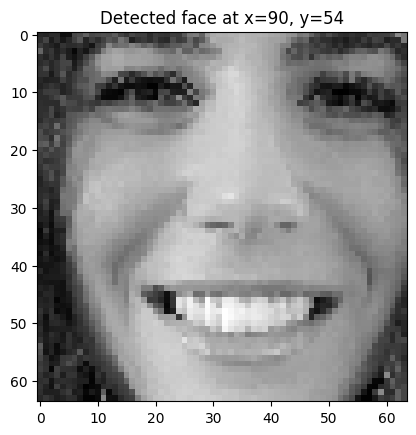

Scanning window at x=93, y=54 -> Prediction: 1.00
Face detected at x=93, y=54 with confidence 1.00


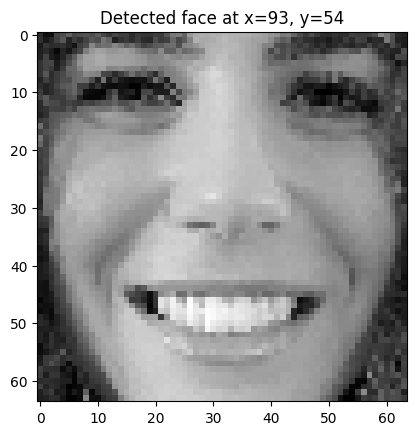

Scanning window at x=96, y=54 -> Prediction: 1.00
Face detected at x=96, y=54 with confidence 1.00


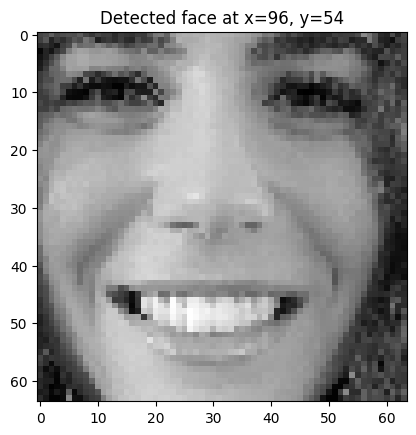

Scanning window at x=99, y=54 -> Prediction: 0.00
Scanning window at x=102, y=54 -> Prediction: 0.00
Scanning window at x=105, y=54 -> Prediction: 0.00
Scanning window at x=108, y=54 -> Prediction: 0.00
Scanning window at x=111, y=54 -> Prediction: 0.00
Scanning window at x=114, y=54 -> Prediction: 0.00
Scanning window at x=117, y=54 -> Prediction: 0.00
Scanning window at x=120, y=54 -> Prediction: 0.00
Scanning window at x=123, y=54 -> Prediction: 0.00
Scanning window at x=126, y=54 -> Prediction: 0.00
Scanning window at x=129, y=54 -> Prediction: 0.00
Scanning window at x=132, y=54 -> Prediction: 0.00
Scanning window at x=135, y=54 -> Prediction: 0.00
Scanning window at x=138, y=54 -> Prediction: 0.00
Scanning window at x=141, y=54 -> Prediction: 0.00
Scanning window at x=144, y=54 -> Prediction: 0.00
Scanning window at x=147, y=54 -> Prediction: 0.00
Scanning window at x=150, y=54 -> Prediction: 0.00
Scanning window at x=153, y=54 -> Prediction: 0.00
Scanning window at x=156, y=54 -

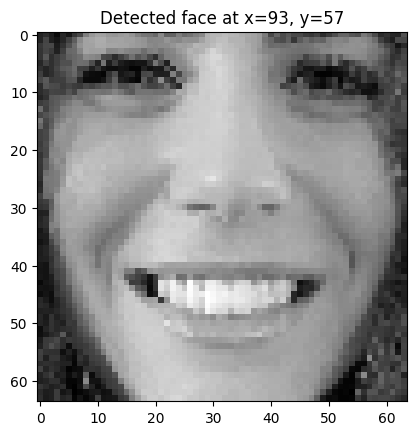

Scanning window at x=96, y=57 -> Prediction: 1.00
Face detected at x=96, y=57 with confidence 1.00


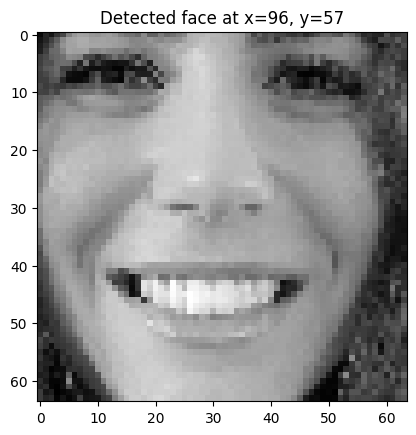

Scanning window at x=99, y=57 -> Prediction: 0.00
Scanning window at x=102, y=57 -> Prediction: 0.00
Scanning window at x=105, y=57 -> Prediction: 0.00
Scanning window at x=108, y=57 -> Prediction: 0.00
Scanning window at x=111, y=57 -> Prediction: 0.00
Scanning window at x=114, y=57 -> Prediction: 0.00
Scanning window at x=117, y=57 -> Prediction: 0.00
Scanning window at x=120, y=57 -> Prediction: 0.00
Scanning window at x=123, y=57 -> Prediction: 0.00
Scanning window at x=126, y=57 -> Prediction: 0.00
Scanning window at x=129, y=57 -> Prediction: 0.00
Scanning window at x=132, y=57 -> Prediction: 0.00
Scanning window at x=135, y=57 -> Prediction: 0.00
Scanning window at x=138, y=57 -> Prediction: 0.00
Scanning window at x=141, y=57 -> Prediction: 0.00
Scanning window at x=144, y=57 -> Prediction: 0.00
Scanning window at x=147, y=57 -> Prediction: 0.00
Scanning window at x=150, y=57 -> Prediction: 0.00
Scanning window at x=153, y=57 -> Prediction: 0.00
Scanning window at x=156, y=57 -

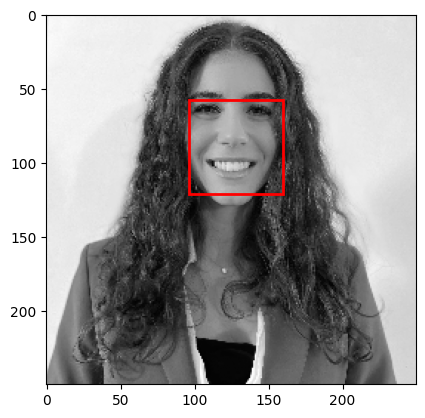

In [ ]:
#face detection
boxes, scores = detect_face(photo_3, face_detection)

#  Non-Maximum Suppression
selected_indices = non_max_suppression(boxes, scores)
filtered_boxes = [boxes[i] for i in selected_indices]

ax = plt.gca()
ax.imshow(cv2.resize(photo_3, (250, 250)), cmap='gray')

for box in filtered_boxes:
    rect = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', linewidth=2, facecolor='none')
    ax.add_patch(rect)

plt.show()


Dimensione immagine: (2591, 2128)
Dimensione finestra mobile: (64, 64), Step Size: 3
Soglia di rilevamento: 0.8
Dimensione immagine post resize: (250, 250)
Scanning window at x=0, y=0 -> Prediction: 0.00
Scanning window at x=3, y=0 -> Prediction: 0.00
Scanning window at x=6, y=0 -> Prediction: 0.00
Scanning window at x=9, y=0 -> Prediction: 0.00
Scanning window at x=12, y=0 -> Prediction: 0.00
Scanning window at x=15, y=0 -> Prediction: 0.00
Scanning window at x=18, y=0 -> Prediction: 0.00
Scanning window at x=21, y=0 -> Prediction: 0.00
Scanning window at x=24, y=0 -> Prediction: 0.00
Scanning window at x=27, y=0 -> Prediction: 0.00
Scanning window at x=30, y=0 -> Prediction: 0.00
Scanning window at x=33, y=0 -> Prediction: 0.00
Scanning window at x=36, y=0 -> Prediction: 0.00
Scanning window at x=39, y=0 -> Prediction: 0.00
Scanning window at x=42, y=0 -> Prediction: 0.00
Scanning window at x=45, y=0 -> Prediction: 0.00
Scanning window at x=48, y=0 -> Prediction: 0.00
Scanning window

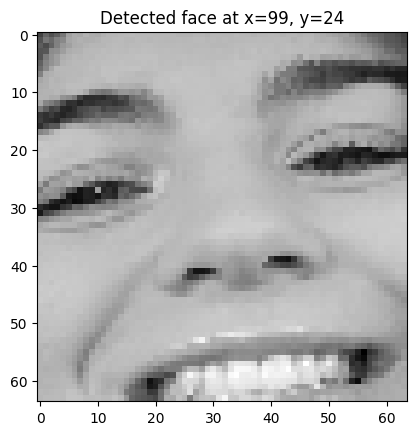

Scanning window at x=102, y=24 -> Prediction: 1.00
Face detected at x=102, y=24 with confidence 1.00


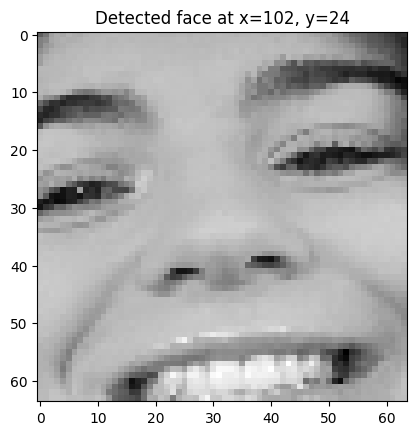

Scanning window at x=105, y=24 -> Prediction: 0.00
Scanning window at x=108, y=24 -> Prediction: 0.00
Scanning window at x=111, y=24 -> Prediction: 0.00
Scanning window at x=114, y=24 -> Prediction: 0.00
Scanning window at x=117, y=24 -> Prediction: 0.00
Scanning window at x=120, y=24 -> Prediction: 0.00
Scanning window at x=123, y=24 -> Prediction: 0.00
Scanning window at x=126, y=24 -> Prediction: 0.00
Scanning window at x=129, y=24 -> Prediction: 0.00
Scanning window at x=132, y=24 -> Prediction: 0.00
Scanning window at x=135, y=24 -> Prediction: 0.00
Scanning window at x=138, y=24 -> Prediction: 0.00
Scanning window at x=141, y=24 -> Prediction: 0.00
Scanning window at x=144, y=24 -> Prediction: 0.00
Scanning window at x=147, y=24 -> Prediction: 0.00
Scanning window at x=150, y=24 -> Prediction: 0.00
Scanning window at x=153, y=24 -> Prediction: 0.00
Scanning window at x=156, y=24 -> Prediction: 0.00
Scanning window at x=159, y=24 -> Prediction: 0.00
Scanning window at x=162, y=24 

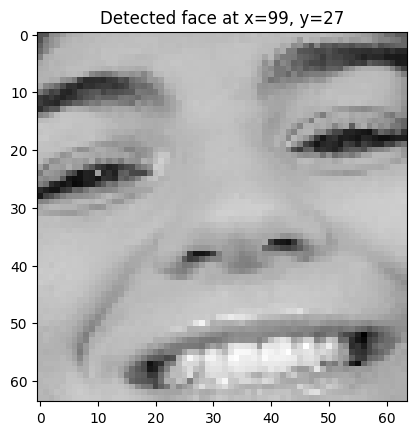

Scanning window at x=102, y=27 -> Prediction: 1.00
Face detected at x=102, y=27 with confidence 1.00


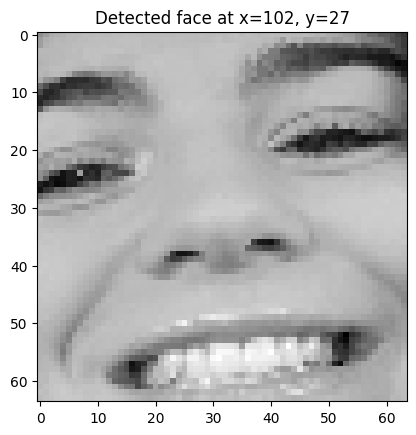

Scanning window at x=105, y=27 -> Prediction: 0.00
Scanning window at x=108, y=27 -> Prediction: 0.00
Scanning window at x=111, y=27 -> Prediction: 0.00
Scanning window at x=114, y=27 -> Prediction: 0.00
Scanning window at x=117, y=27 -> Prediction: 0.00
Scanning window at x=120, y=27 -> Prediction: 0.00
Scanning window at x=123, y=27 -> Prediction: 0.00
Scanning window at x=126, y=27 -> Prediction: 0.00
Scanning window at x=129, y=27 -> Prediction: 0.00
Scanning window at x=132, y=27 -> Prediction: 0.00
Scanning window at x=135, y=27 -> Prediction: 0.00
Scanning window at x=138, y=27 -> Prediction: 0.00
Scanning window at x=141, y=27 -> Prediction: 0.00
Scanning window at x=144, y=27 -> Prediction: 0.00
Scanning window at x=147, y=27 -> Prediction: 0.00
Scanning window at x=150, y=27 -> Prediction: 0.00
Scanning window at x=153, y=27 -> Prediction: 0.00
Scanning window at x=156, y=27 -> Prediction: 0.00
Scanning window at x=159, y=27 -> Prediction: 0.00
Scanning window at x=162, y=27 

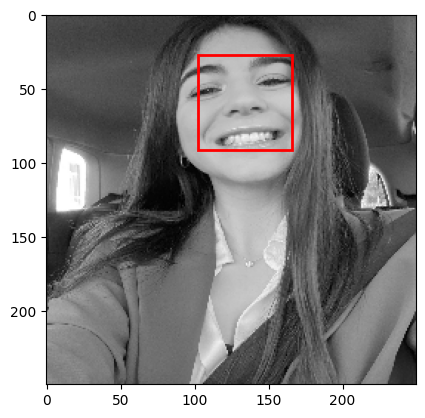

In [ ]:
# face detection
boxes, scores = detect_face(photo_2, face_detection)

# -Maximum Suppression
selected_indices = non_max_suppression(boxes, scores)
filtered_boxes = [boxes[i] for i in selected_indices]

ax = plt.gca()
ax.imshow(cv2.resize(photo_2, (250, 250)), cmap='gray')

for box in filtered_boxes:
    rect = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', linewidth=2, facecolor='none')
    ax.add_patch(rect)

plt.show()

Dimensione immagine: (2559, 2559)
Dimensione finestra mobile: (64, 64), Step Size: 3
Soglia di rilevamento: 0.8
Dimensione immagine post resize: (250, 250)
Scanning window at x=0, y=0 -> Prediction: 0.00
Scanning window at x=3, y=0 -> Prediction: 0.00
Scanning window at x=6, y=0 -> Prediction: 0.00
Scanning window at x=9, y=0 -> Prediction: 0.00
Scanning window at x=12, y=0 -> Prediction: 0.00
Scanning window at x=15, y=0 -> Prediction: 0.00
Scanning window at x=18, y=0 -> Prediction: 0.00
Scanning window at x=21, y=0 -> Prediction: 0.00
Scanning window at x=24, y=0 -> Prediction: 0.00
Scanning window at x=27, y=0 -> Prediction: 0.00
Scanning window at x=30, y=0 -> Prediction: 0.00
Scanning window at x=33, y=0 -> Prediction: 0.00
Scanning window at x=36, y=0 -> Prediction: 0.00
Scanning window at x=39, y=0 -> Prediction: 0.00
Scanning window at x=42, y=0 -> Prediction: 0.00
Scanning window at x=45, y=0 -> Prediction: 0.00
Scanning window at x=48, y=0 -> Prediction: 0.00
Scanning window

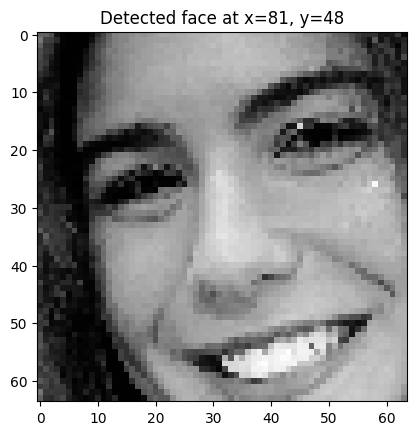

Scanning window at x=84, y=48 -> Prediction: 1.00
Face detected at x=84, y=48 with confidence 1.00


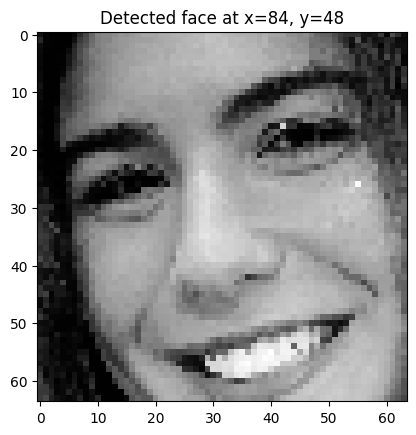

Scanning window at x=87, y=48 -> Prediction: 1.00
Face detected at x=87, y=48 with confidence 1.00


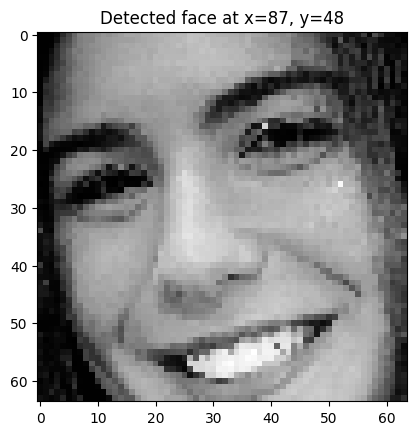

Scanning window at x=90, y=48 -> Prediction: 0.00
Scanning window at x=93, y=48 -> Prediction: 0.00
Scanning window at x=96, y=48 -> Prediction: 0.00
Scanning window at x=99, y=48 -> Prediction: 0.00
Scanning window at x=102, y=48 -> Prediction: 0.00
Scanning window at x=105, y=48 -> Prediction: 0.00
Scanning window at x=108, y=48 -> Prediction: 0.00
Scanning window at x=111, y=48 -> Prediction: 0.00
Scanning window at x=114, y=48 -> Prediction: 0.00
Scanning window at x=117, y=48 -> Prediction: 0.00
Scanning window at x=120, y=48 -> Prediction: 0.00
Scanning window at x=123, y=48 -> Prediction: 0.00
Scanning window at x=126, y=48 -> Prediction: 0.00
Scanning window at x=129, y=48 -> Prediction: 0.00
Scanning window at x=132, y=48 -> Prediction: 0.00
Scanning window at x=135, y=48 -> Prediction: 0.00
Scanning window at x=138, y=48 -> Prediction: 0.00
Scanning window at x=141, y=48 -> Prediction: 0.00
Scanning window at x=144, y=48 -> Prediction: 0.00
Scanning window at x=147, y=48 -> P

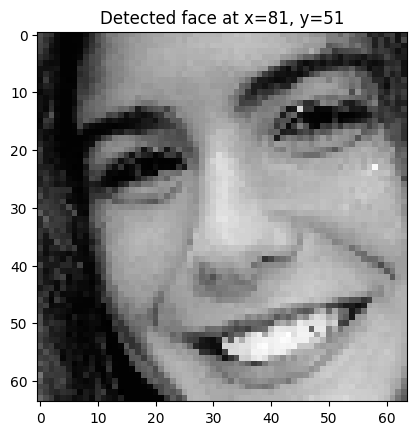

Scanning window at x=84, y=51 -> Prediction: 1.00
Face detected at x=84, y=51 with confidence 1.00


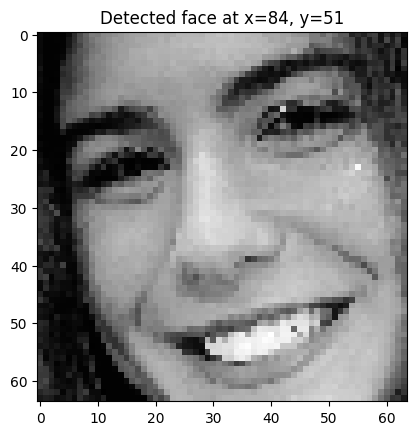

Scanning window at x=87, y=51 -> Prediction: 1.00
Face detected at x=87, y=51 with confidence 1.00


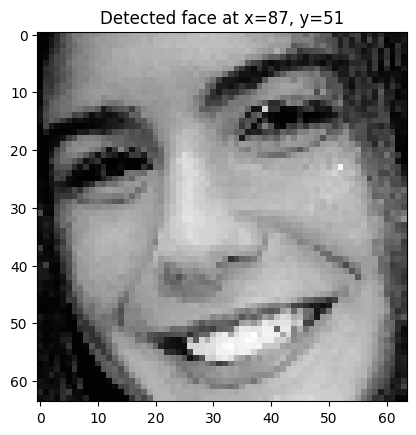

Scanning window at x=90, y=51 -> Prediction: 0.00
Scanning window at x=93, y=51 -> Prediction: 0.00
Scanning window at x=96, y=51 -> Prediction: 0.00
Scanning window at x=99, y=51 -> Prediction: 0.00
Scanning window at x=102, y=51 -> Prediction: 0.00
Scanning window at x=105, y=51 -> Prediction: 0.00
Scanning window at x=108, y=51 -> Prediction: 0.00
Scanning window at x=111, y=51 -> Prediction: 0.00
Scanning window at x=114, y=51 -> Prediction: 0.00
Scanning window at x=117, y=51 -> Prediction: 0.00
Scanning window at x=120, y=51 -> Prediction: 0.00
Scanning window at x=123, y=51 -> Prediction: 0.00
Scanning window at x=126, y=51 -> Prediction: 0.00
Scanning window at x=129, y=51 -> Prediction: 0.00
Scanning window at x=132, y=51 -> Prediction: 0.00
Scanning window at x=135, y=51 -> Prediction: 0.00
Scanning window at x=138, y=51 -> Prediction: 0.00
Scanning window at x=141, y=51 -> Prediction: 0.00
Scanning window at x=144, y=51 -> Prediction: 0.00
Scanning window at x=147, y=51 -> P

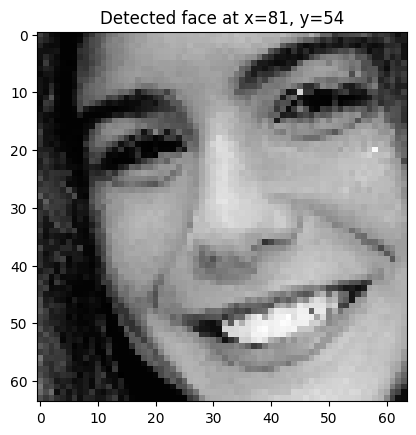

Scanning window at x=84, y=54 -> Prediction: 1.00
Face detected at x=84, y=54 with confidence 1.00


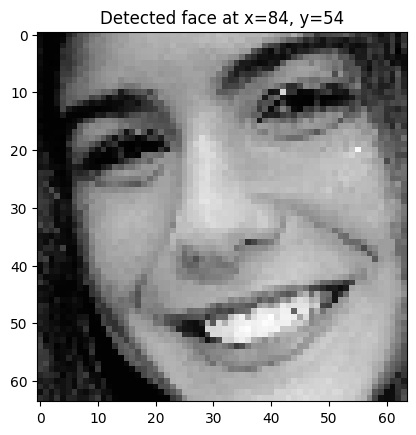

Scanning window at x=87, y=54 -> Prediction: 1.00
Face detected at x=87, y=54 with confidence 1.00


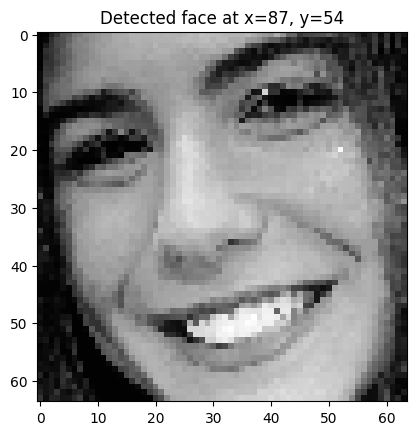

Scanning window at x=90, y=54 -> Prediction: 0.00
Scanning window at x=93, y=54 -> Prediction: 0.00
Scanning window at x=96, y=54 -> Prediction: 0.00
Scanning window at x=99, y=54 -> Prediction: 0.00
Scanning window at x=102, y=54 -> Prediction: 0.00
Scanning window at x=105, y=54 -> Prediction: 0.00
Scanning window at x=108, y=54 -> Prediction: 0.00
Scanning window at x=111, y=54 -> Prediction: 0.00
Scanning window at x=114, y=54 -> Prediction: 0.00
Scanning window at x=117, y=54 -> Prediction: 0.00
Scanning window at x=120, y=54 -> Prediction: 0.00
Scanning window at x=123, y=54 -> Prediction: 0.00
Scanning window at x=126, y=54 -> Prediction: 0.00
Scanning window at x=129, y=54 -> Prediction: 0.00
Scanning window at x=132, y=54 -> Prediction: 0.00
Scanning window at x=135, y=54 -> Prediction: 0.00
Scanning window at x=138, y=54 -> Prediction: 0.00
Scanning window at x=141, y=54 -> Prediction: 0.00
Scanning window at x=144, y=54 -> Prediction: 0.00
Scanning window at x=147, y=54 -> P

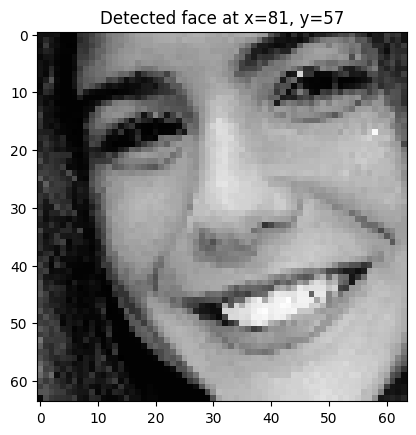

Scanning window at x=84, y=57 -> Prediction: 1.00
Face detected at x=84, y=57 with confidence 1.00


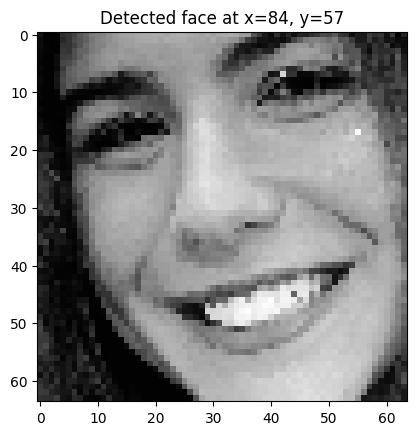

Scanning window at x=87, y=57 -> Prediction: 1.00
Face detected at x=87, y=57 with confidence 1.00


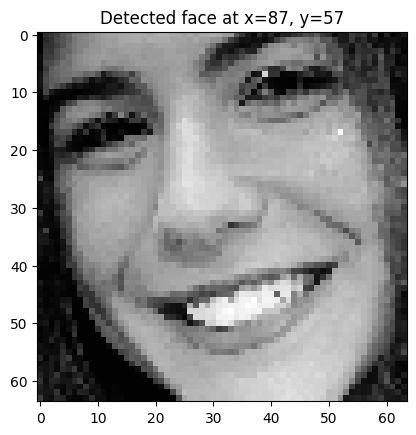

Scanning window at x=90, y=57 -> Prediction: 0.00
Scanning window at x=93, y=57 -> Prediction: 0.00
Scanning window at x=96, y=57 -> Prediction: 0.00
Scanning window at x=99, y=57 -> Prediction: 0.00
Scanning window at x=102, y=57 -> Prediction: 0.00
Scanning window at x=105, y=57 -> Prediction: 0.00
Scanning window at x=108, y=57 -> Prediction: 0.00
Scanning window at x=111, y=57 -> Prediction: 0.00
Scanning window at x=114, y=57 -> Prediction: 0.00
Scanning window at x=117, y=57 -> Prediction: 0.00
Scanning window at x=120, y=57 -> Prediction: 0.00
Scanning window at x=123, y=57 -> Prediction: 0.00
Scanning window at x=126, y=57 -> Prediction: 0.00
Scanning window at x=129, y=57 -> Prediction: 0.00
Scanning window at x=132, y=57 -> Prediction: 0.00
Scanning window at x=135, y=57 -> Prediction: 0.00
Scanning window at x=138, y=57 -> Prediction: 0.00
Scanning window at x=141, y=57 -> Prediction: 0.00
Scanning window at x=144, y=57 -> Prediction: 0.00
Scanning window at x=147, y=57 -> P

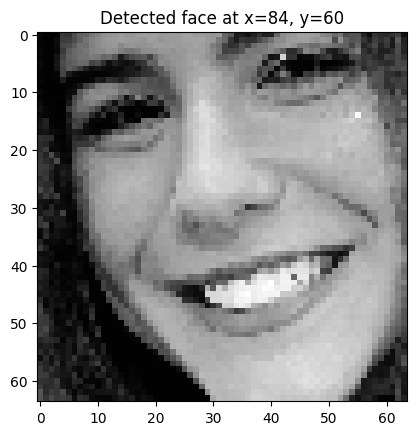

Scanning window at x=87, y=60 -> Prediction: 0.00
Scanning window at x=90, y=60 -> Prediction: 0.00
Scanning window at x=93, y=60 -> Prediction: 0.00
Scanning window at x=96, y=60 -> Prediction: 0.00
Scanning window at x=99, y=60 -> Prediction: 0.00
Scanning window at x=102, y=60 -> Prediction: 0.00
Scanning window at x=105, y=60 -> Prediction: 0.00
Scanning window at x=108, y=60 -> Prediction: 0.00
Scanning window at x=111, y=60 -> Prediction: 0.00
Scanning window at x=114, y=60 -> Prediction: 0.00
Scanning window at x=117, y=60 -> Prediction: 0.00
Scanning window at x=120, y=60 -> Prediction: 0.00
Scanning window at x=123, y=60 -> Prediction: 0.00
Scanning window at x=126, y=60 -> Prediction: 0.00
Scanning window at x=129, y=60 -> Prediction: 0.00
Scanning window at x=132, y=60 -> Prediction: 0.00
Scanning window at x=135, y=60 -> Prediction: 0.00
Scanning window at x=138, y=60 -> Prediction: 0.00
Scanning window at x=141, y=60 -> Prediction: 0.00
Scanning window at x=144, y=60 -> Pr

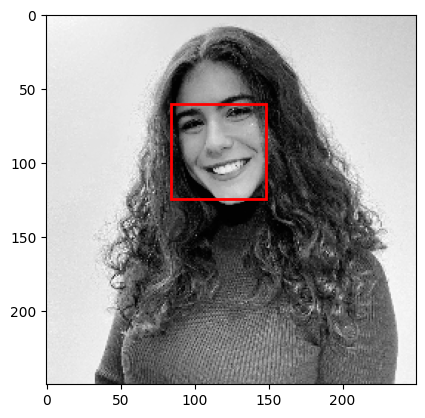

In [ ]:
# face detection
boxes, scores = detect_face(photo, face_detection)

# Non-Maximum Suppression
selected_indices = non_max_suppression(boxes, scores)
filtered_boxes = [boxes[i] for i in selected_indices]

ax = plt.gca()
ax.imshow(cv2.resize(photo, (250, 250)), cmap='gray')

for box in filtered_boxes:
    rect = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', linewidth=2, facecolor='none')
    ax.add_patch(rect)

plt.show()

## Commenti finali

Come già precedentemente citato, le metriche fanno sospettare possibile overfitting del modello. Tuttavia, con delle immagini nuove e di dimensioni variabili, il modello è riusciuto ad individuare correttamente la presenza di tutti i volti.

 Un punto su cui mettere attenzione è anche quello relativo alla risoluzione delle immagini, parametro a cui il modello è molto sensibile. In questo caso si è deciso di effettuare un resize delle immagini in considerazione per renderle compatibili con la finestra di scorrimento e con quanto fornito al modello in fase di addestramento, tenendo conto che l'assunzione sia che verrà utilizzato per selfie e non per foto da lontano (come esplicato già in precedenza).


Per concludere, possibili miglioramenti futuri del modello potrebbero essere legati alla scelta di un dataset più ampio e con maggiore variabilità per l'addestramento, nonchè provvisto di immagini di varia risoluzione. Allo stesso tempo, si potrebbe tentare di creare una finestra di dimensioni "dinamiche" per rendere possibile l'individuazione anche di volti non in primo piano, cercando di conciliare il tutto con il potere computazionale della macchina in uso. I risultati ottenuti ad oggi permettono di affermare che, sebbene le piccole criticità, il modello rappresenta un buon compromesso tra performance e velocità di esecuzione (un paio di minuti scarsi).